## **LSTM Grid Search for Crypto Lending and Borrowing Rates**

**1. Observations and Initial Setup:** Based on the observations, we notice that either we are not learning anything important from the training or we are not generalizing well, as indicated by the different results in the validation. We start by loading necessary extensions and importing the required libraries for data manipulation, machine learning, and database interaction.

**2. Training the LSTM Model:** We initialize empty lists to store aggregated inputs and targets, and concatenate them into single arrays. We then train the LSTM model using the extracted input and output windows, and evaluate its performance using various metrics such as accuracy, precision, recall, and F1 score.

**3. Performing Grid Search on Input and Output Windows:** We perform a grid search on the base architecture of the LSTM model, experimenting with different combinations of input and output windows. We store the results of each combination in a DataFrame and save them to CSV files. The results indicate overfitting for 48 input and 48 output windows, and good performance for 96 input and 8 output windows, which need more epochs to converge.

**4. Regularization and Early Stopping:** We test regularization and early stopping to address overfitting. We train the LSTM model with L2 regularization and early stopping, but the results do not improve, so we decide not to use this model.

**5. Grid Search on Optimizers and Dropout Rates:** We experiment with different optimizers and dropout rates to improve generalization. We perform a grid search with various combinations of optimizers, cell sizes, and dropout rates. The results indicate that the best performance is achieved with the RMSprop optimizer, 40 cell size, and 0.1 dropout rate.

**6. Further Optimization:** We further optimize by testing smaller dropouts and smaller cell sizes. The results show that smaller dropouts and smaller window sizes tend to perform better. We also test the RMSprop optimizer without dropouts, but the results indicate that dropouts are needed and very low cell sizes do not help with performance.

**7. Conclusion:** The notebook concludes with the analysis of the grid search results, providing insights into the best-performing configurations for the LSTM model. This includes the optimal input features, outlier thresholds, loss functions, and input/output windows for accurate predictions. The final results show that dropouts are necessary for better performance and very low cell sizes are not beneficial.

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import utils as pre
import warnings
warnings.filterwarnings('ignore')

In [2]:
connection = pre.connect_to_database()
if connection:
    # Query merged data
    merged_df = pre.query_merged_crypto_data(connection)
    # converting US bond yield from hourly to yearly under continous compounding assumptions
    merged_df['yield'] = np.exp(merged_df['yield']*365*24)-1

    # Close the connection
    pre.query_quit(connection)

merged_df.head(3)

Connected to MySQL database, MySQL Server version:  8.0.39
MySQL connection is closed


lending_rate borrowing_rate utilization_rate stable_borrow_rate  \
0   -50.000000     -50.000000       -50.000000           0.030000   
1   -50.000000     -50.000000       -50.000000           0.030000   
2   -50.000000     -50.000000         0.013598           0.030000   

  crypto_symbol                date  high   low close adj_close   volume  \
0       BATUSDT 2020-12-02 14:00:00  0.24  0.24  0.24      0.24  1294545   
1       BATUSDT 2020-12-02 15:00:00  0.24  0.24  0.24      0.24   936344   
2       BATUSDT 2020-12-02 16:00:00  0.24  0.24  0.24      0.24   724626   

  market_cap coin_supply                          yield  
0       None        None  0.008552840317602313182744400  
1       None        None  0.008552840317602313182744400  
2       None        None  0.008552840317602313182744400

### merging with market cap

In [3]:
market_caps = pd.read_csv('market_cap_data.csv')
market_caps = market_caps.rename(columns={
    'timestamp': 'date',
    'token': 'crypto_symbol',
})
market_caps.head(3)

Unnamed: 0                 date  market_cap crypto_symbol
0           0  2020-12-21 00:00:00    87121414     1INCHUSDT
1           1  2020-12-21 01:00:00    87121414     1INCHUSDT
2           2  2020-12-21 02:00:00    87121414     1INCHUSDT

In [4]:
# Convert 'date' columns to pandas datetime format
merged_df['date'] = pd.to_datetime(merged_df['date'])
market_caps['date'] = pd.to_datetime(market_caps['date'])

# Perform the merge based on 'crypto_symbol' and 'date', keeping only rows in merged_df
merged_df.drop('market_cap', axis = 1, inplace=True)
merged_df = pd.merge(
    merged_df,
    market_caps[['date', 'market_cap', 'crypto_symbol']],
    on=['date', 'crypto_symbol'],
    how='left'
)

merged_df.head(3)

lending_rate borrowing_rate utilization_rate stable_borrow_rate  \
0   -50.000000     -50.000000       -50.000000           0.030000   
1   -50.000000     -50.000000       -50.000000           0.030000   
2   -50.000000     -50.000000         0.013598           0.030000   

  crypto_symbol                date  high   low close adj_close   volume  \
0       BATUSDT 2020-12-02 14:00:00  0.24  0.24  0.24      0.24  1294545   
1       BATUSDT 2020-12-02 15:00:00  0.24  0.24  0.24      0.24   936344   
2       BATUSDT 2020-12-02 16:00:00  0.24  0.24  0.24      0.24   724626   

  coin_supply                          yield   market_cap  
0        None  0.008552840317602313182744400  317700843.0  
1        None  0.008552840317602313182744400  317700843.0  
2        None  0.008552840317602313182744400  317700843.0

In [8]:
# KNC has wrong data before 2021
merged_df = merged_df[merged_df['market_cap'].notna()]
merged_df.reset_index(inplace = True, drop=True)

In [9]:
merged_df_emb = pre.create_llm_embeddings(merged_df, "crypto_symbol", n_components=15)
merged_df_emb = pre.create_cyclical_encodings(merged_df_emb, "date")

In [10]:
merged_df_emb.columns

Index(['lending_rate', 'borrowing_rate', 'utilization_rate',
       'stable_borrow_rate', 'crypto_symbol', 'date', 'high', 'low', 'close',
       'adj_close', 'volume', 'coin_supply', 'yield', 'market_cap',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine'],
      dtype='object')

In [11]:
# data without NA rows if we needed 
filtered_df = merged_df_emb[(merged_df['borrowing_rate'] != -50)&(merged_df['lending_rate'] != -50)&(merged_df['utilization_rate'] != -50)]
filtered_df['attention'] = filtered_df['volume'] * filtered_df['close']
filtered_df.drop(columns=['stable_borrow_rate','adj_close','coin_supply'], inplace=True)
filtered_df[['lending_rate','borrowing_rate','utilization_rate','close', 'volume']] = filtered_df[['lending_rate','borrowing_rate','utilization_rate','close', 'volume']].astype(float)
# removing wbtc because of its small amuont of data in 2024
filtered_df = filtered_df[filtered_df['crypto_symbol'] != 'WBTCUSDT']
filtered_df.reset_index(inplace=True, drop=True)
print(len(filtered_df))
filtered_df.columns

401976


Index(['lending_rate', 'borrowing_rate', 'utilization_rate', 'crypto_symbol',
       'date', 'high', 'low', 'close', 'volume', 'yield', 'market_cap',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine', 'attention'],
      dtype='object')

In [12]:
# We scale  market cap, attention, yield together as they are comparable
scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)
filtered_df['yield'] = scaler.fit_transform(filtered_df[['yield']])
filtered_df['market_cap'] = scaler.fit_transform(filtered_df[['market_cap']])
filtered_df['attention'] = scaler.fit_transform(filtered_df[['attention']])

In [13]:
input_columns = ['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention','returns', 'volume'] 
input_output_combination = [
     {'input':48, 'output':48},
     {'input':96, 'output':8}
]
outlier_threshold = 'remove'
epoch_num = 50
bacth_size = 200
balancer = 2

preprocessing...
length of train, valid, test: 
(70549, 48, 8)
(41323, 48, 8)
(56869, 48, 8)
affter balancing distribution:
(70549, 48, 8)
borrow_rate_Y_train: [20945 27433 22171]
borrow_rate_Y_valid: [23487 14377  3459]
borrow_rate_Y_test: [32957 12219 11693]
Training...



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 80)                28480     
                                                                 
 dense (Dense)               (None, 3)                 243       
                                                                 
Total params: 28723 (112.20 KB)
Trainable params: 28723 (112.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


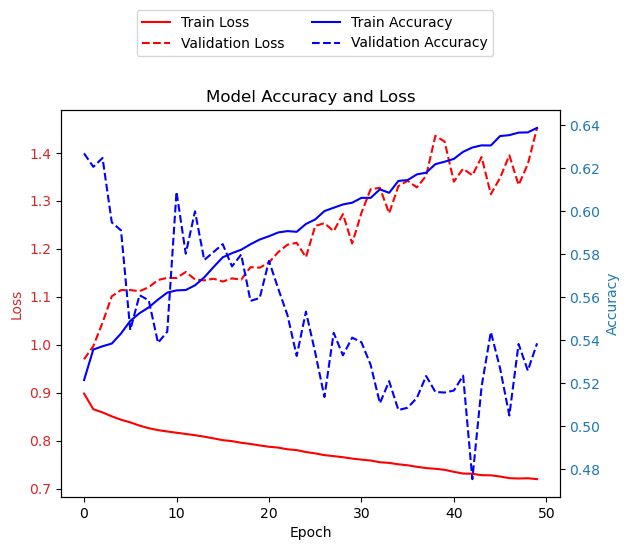

1778/1778 [==============================] - 8s 4ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.4943114878053069, 'precision': 0.4062405681860513, 'recall': 0.41238361791927636, 'f1': 0.4060852394243711}
preprocessing...
length of train, valid, test: 
(65814, 96, 8)
(40212, 96, 8)
(55755, 96, 8)
affter balancing distribution:
(48155, 96, 8)
borrow_rate_Y_train: [23540 12845 11770]
borrow_rate_Y_valid: [35082  4278   852]
borrow_rate_Y_test: [49910  2985  2860]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 80)  

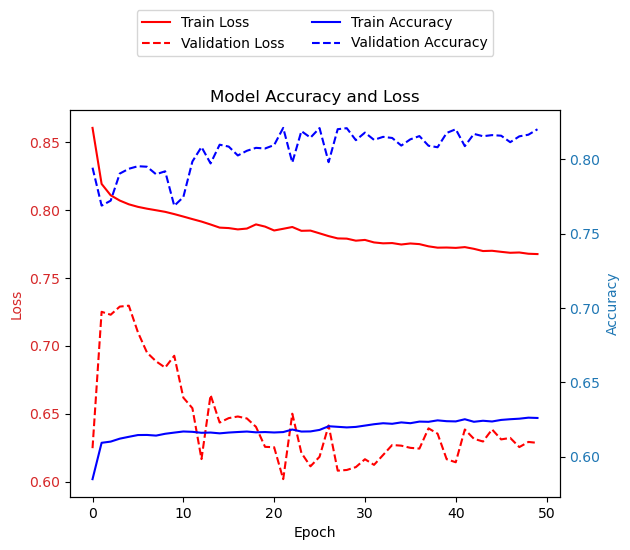

1743/1743 [==============================] - 14s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'accuracy': 0.8012913640032284, 'precision': 0.35856388080614554, 'recall': 0.3710867625979652, 'f1': 0.34942518307667375}


In [14]:
# a simple one layer LSTM
results_arr_2 = []
for comb in input_output_combination: 
    try:
        print('preprocessing...')
        input_window = comb['input'] #***
        output_window = comb['output'] #***

        # Initialize empty lists to store aggregated inputs and targets
        X_train,X_valid,X_test = [], [], []
        Y_train,Y_valid,Y_test = [], [], []
        # looping through symbols
        symbols = filtered_df['crypto_symbol'].unique()
        for s in symbols:
            try:
                sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                sim_df.reset_index(inplace=True, drop=True)
                
                # First Loop: Calculate intervals for each column without modifying the DataFrame
                intervals = {}
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                    intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                    # getting the returns
                reduced_df = sim_df.copy()
                reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                reduced_df = reduced_df[reduced_df['returns'].notna()]
                reduced_df.reset_index(inplace=True, drop=True)

                # Second Loop: Filter rows based on the pre-calculated intervals
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower_bound = intervals[column]['lower_bound']
                    upper_bound = intervals[column]['upper_bound']
                    # Apply filtering based on pre-calculated bounds
                    reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                reduced_df.reset_index(inplace=True, drop=True)

                # MinMax scaling
                scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                scaled_df = reduced_df.copy()
                scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                inputs_train, inputs_valid, inputs_test, targets_train, targets_valid, targets_test = pre.extract_valid_windows_v4(scaled_df,
                'date', input_window, output_window, input_columns, ['lending_rate','borrowing_rate'],train_end_date="2023-07-01 00:00:00", valid_end_date="2024-01-25 00:00:00")

                # Append results from the current DataFrame
                X_train.append(inputs_train)
                X_valid.append(inputs_valid)
                X_test.append(inputs_test)
                Y_train.append(targets_train)
                Y_valid.append(targets_valid)
                Y_test.append(targets_test)

            # Handle any other exceptions
            except Exception as e:
                print(f"Unexpected error in symbol {s}: {e}")

        # Concatenate all inputs and targets into single arrays
        X_train = [arr for arr in X_train if len(arr) > 0]
        X_valid = [arr for arr in X_valid if len(arr) > 0]
        X_test = [arr for arr in X_test if len(arr) > 0]

        Y_train = [arr for arr in Y_train if len(arr) > 0]
        Y_valid = [arr for arr in Y_valid if len(arr) > 0]
        Y_test = [arr for arr in Y_test if len(arr) > 0]

        X_train  = np.concatenate(X_train, axis=0) if X_train else np.array([])
        X_valid = np.concatenate(X_valid, axis=0) if X_valid else np.array([])
        X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])

        Y_train  = np.concatenate(Y_train, axis=0) if Y_train else np.array([])
        Y_valid = np.concatenate(Y_valid, axis=0) if Y_valid else np.array([])
        Y_test  = np.concatenate(Y_test, axis=0) if Y_test else np.array([])
        # Lending rate
        lending_rate_Y_train = Y_train[:, 0].reshape(Y_train.shape[0], 1) 
        lending_rate_Y_valid = Y_valid[:, 0].reshape(Y_valid.shape[0], 1) 
        lending_rate_Y_test = Y_test[:, 0].reshape(Y_test.shape[0], 1) 
        # Borrowing rate
        borrow_rate_Y_train = Y_train[:, 1].reshape(Y_train.shape[0], 1) 
        borrow_rate_Y_valid = Y_valid[:, 1].reshape(Y_valid.shape[0], 1) 
        borrow_rate_Y_test = Y_test[:, 1].reshape(Y_test.shape[0], 1) 

        print('length of train, valid, test: ')
        print(X_train.shape)
        print(X_valid.shape)
        print(X_test.shape)

        # Apply rebalancing
        X_train, borrow_rate_Y_train = pre.rebalance_classes_general(X_train, borrow_rate_Y_train, balance_ratio=balancer)

        print("affter balancing distribution:")
        print(X_train.shape)
        print('borrow_rate_Y_train:', np.bincount(borrow_rate_Y_train.flatten()))
        print('borrow_rate_Y_valid:',np.bincount(borrow_rate_Y_valid.flatten()))
        print('borrow_rate_Y_test:',np.bincount(borrow_rate_Y_test.flatten()))

        print('Training...')
        Y_test, y_pred = pre.train_v6(X_train,X_valid,X_test,borrow_rate_Y_train,borrow_rate_Y_valid,borrow_rate_Y_test, details=True,epochs=epoch_num, batch_size=bacth_size)
        
        accuracy, precision, recall, f1 = pre.classification_metrics(Y_test, y_pred, printed = False)

        total_windows = Y_test.shape[0]
            
        new_row = {
            'columns': f'{input_columns}',
            'total_test_windows':total_windows,
            'input_window':input_window,
            'output_window':output_window, 
            'outlier_threshold':outlier_threshold, 
            'accuracy':accuracy, 
            'precision':precision, 
            'recall':recall, 
            'f1':f1
        }
        results_arr_2.append(new_row)
        print(new_row)
        
    except Exception as e:
        print(f"Error occurred with {input_columns}")
        print(f"Exception details: {e}")

results = pd.DataFrame(results_arr_2)

In [15]:
results.to_csv('one_layer_LSTM.csv')
results

columns  total_test_windows  \
0  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
1  ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   

   input_window  output_window outlier_threshold  accuracy  precision  \
0            48             48            remove  0.494311   0.406241   
1            96              8            remove  0.801291   0.358564   

     recall        f1  
0  0.412384  0.406085  
1  0.371087  0.349425

### The results for 48 input and 48 output shows overfitting that is why we will test regularization and early stopping
### The results for 98 input and 8 output is good but it need to be run for more epochs to converge

preprocessing...
length of train, valid, test: 
(70549, 48, 8)
(41323, 48, 8)
(56869, 48, 8)
affter balancing distribution:
(70549, 48, 8)
borrow_rate_Y_train: [20945 27433 22171]
borrow_rate_Y_valid: [23487 14377  3459]
borrow_rate_Y_test: [32957 12219 11693]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 80)                28480     
                                                                 
 dense (Dense)               (None, 3)                 243       
                                                                 
Total params: 28723 (112.20 KB)
Trainable params: 28723 (112.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


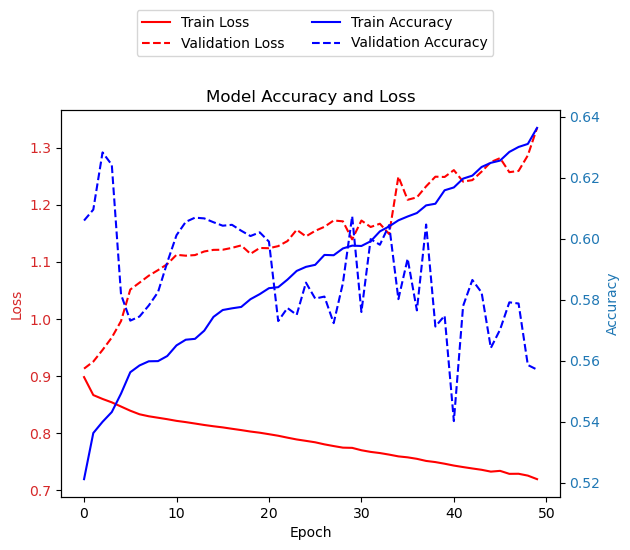

1778/1778 [==============================] - 8s 4ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.46301148253002516, 'precision': 0.3632563270602088, 'recall': 0.3636334984958957, 'f1': 0.363406014836493}
preprocessing...
length of train, valid, test: 
(65814, 96, 8)
(40212, 96, 8)
(55755, 96, 8)
affter balancing distribution:
(48155, 96, 8)
borrow_rate_Y_train: [23540 12845 11770]
borrow_rate_Y_valid: [35082  4278   852]
borrow_rate_Y_test: [49910  2985  2860]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 80)   

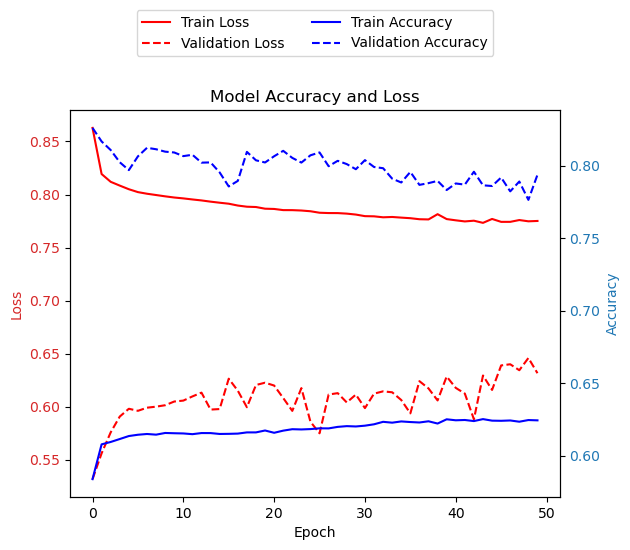

1743/1743 [==============================] - 14s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'accuracy': 0.7946551878755269, 'precision': 0.35631890617864964, 'recall': 0.3586341471584658, 'f1': 0.34360314136959463}


In [16]:
# simple LSTM with L2 - regularization and early stopping
results_arr_3 = []
for comb in input_output_combination: 
    try:
        print('preprocessing...')
        input_window = comb['input'] #***
        output_window = comb['output'] #***

        # Initialize empty lists to store aggregated inputs and targets
        X_train,X_valid,X_test = [], [], []
        Y_train,Y_valid,Y_test = [], [], []
        # looping through symbols
        symbols = filtered_df['crypto_symbol'].unique()
        for s in symbols:
            try:
                sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                sim_df.reset_index(inplace=True, drop=True)
                
                # First Loop: Calculate intervals for each column without modifying the DataFrame
                intervals = {}
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                    intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                    # getting the returns
                reduced_df = sim_df.copy()
                reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                reduced_df = reduced_df[reduced_df['returns'].notna()]
                reduced_df.reset_index(inplace=True, drop=True)

                # Second Loop: Filter rows based on the pre-calculated intervals
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower_bound = intervals[column]['lower_bound']
                    upper_bound = intervals[column]['upper_bound']
                    # Apply filtering based on pre-calculated bounds
                    reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                reduced_df.reset_index(inplace=True, drop=True)

                # MinMax scaling
                scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                scaled_df = reduced_df.copy()
                scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                inputs_train, inputs_valid, inputs_test, targets_train, targets_valid, targets_test = pre.extract_valid_windows_v4(scaled_df,
                'date', input_window, output_window, input_columns, ['lending_rate','borrowing_rate'],train_end_date="2023-07-01 00:00:00", valid_end_date="2024-01-25 00:00:00")

                # Append results from the current DataFrame
                X_train.append(inputs_train)
                X_valid.append(inputs_valid)
                X_test.append(inputs_test)
                Y_train.append(targets_train)
                Y_valid.append(targets_valid)
                Y_test.append(targets_test)

            # Handle any other exceptions
            except Exception as e:
                print(f"Unexpected error in symbol {s}: {e}")

        # Concatenate all inputs and targets into single arrays
        X_train = [arr for arr in X_train if len(arr) > 0]
        X_valid = [arr for arr in X_valid if len(arr) > 0]
        X_test = [arr for arr in X_test if len(arr) > 0]

        Y_train = [arr for arr in Y_train if len(arr) > 0]
        Y_valid = [arr for arr in Y_valid if len(arr) > 0]
        Y_test = [arr for arr in Y_test if len(arr) > 0]

        X_train  = np.concatenate(X_train, axis=0) if X_train else np.array([])
        X_valid = np.concatenate(X_valid, axis=0) if X_valid else np.array([])
        X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])

        Y_train  = np.concatenate(Y_train, axis=0) if Y_train else np.array([])
        Y_valid = np.concatenate(Y_valid, axis=0) if Y_valid else np.array([])
        Y_test  = np.concatenate(Y_test, axis=0) if Y_test else np.array([])
        # Lending rate
        lending_rate_Y_train = Y_train[:, 0].reshape(Y_train.shape[0], 1) 
        lending_rate_Y_valid = Y_valid[:, 0].reshape(Y_valid.shape[0], 1) 
        lending_rate_Y_test = Y_test[:, 0].reshape(Y_test.shape[0], 1) 
        # Borrowing rate
        borrow_rate_Y_train = Y_train[:, 1].reshape(Y_train.shape[0], 1) 
        borrow_rate_Y_valid = Y_valid[:, 1].reshape(Y_valid.shape[0], 1) 
        borrow_rate_Y_test = Y_test[:, 1].reshape(Y_test.shape[0], 1) 

        print('length of train, valid, test: ')
        print(X_train.shape)
        print(X_valid.shape)
        print(X_test.shape)

        # Apply rebalancing
        X_train, borrow_rate_Y_train = pre.rebalance_classes_general(X_train, borrow_rate_Y_train, balance_ratio=balancer)

        print("affter balancing distribution:")
        print(X_train.shape)
        print('borrow_rate_Y_train:', np.bincount(borrow_rate_Y_train.flatten()))
        print('borrow_rate_Y_valid:',np.bincount(borrow_rate_Y_valid.flatten()))
        print('borrow_rate_Y_test:',np.bincount(borrow_rate_Y_test.flatten()))

        print('Training...')
        Y_test, y_pred = pre.train_v6(X_train,X_valid,X_test,borrow_rate_Y_train,borrow_rate_Y_valid,borrow_rate_Y_test, details=True,epochs=epoch_num, batch_size=bacth_size)
        
        accuracy, precision, recall, f1 = pre.classification_metrics(Y_test, y_pred, printed = False)

        total_windows = Y_test.shape[0]
            
        new_row = {
            'columns': f'{input_columns}',
            'total_test_windows':total_windows,
            'input_window':input_window,
            'output_window':output_window, 
            'outlier_threshold':outlier_threshold, 
            'accuracy':accuracy, 
            'precision':precision, 
            'recall':recall, 
            'f1':f1
        }
        results_arr_3.append(new_row)
        print(new_row)
        
    except Exception as e:
        print(f"Error occurred with {input_columns}")
        print(f"Exception details: {e}")

results = pd.DataFrame(results_arr_3)

In [17]:
results.to_csv('one_layer_LSTM_regularized.csv')
results

columns  total_test_windows  \
0  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
1  ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   

   input_window  output_window outlier_threshold  accuracy  precision  \
0            48             48            remove  0.463011   0.363256   
1            96              8            remove  0.794655   0.356319   

     recall        f1  
0  0.363633  0.363406  
1  0.358634  0.343603

### The results are not getting better with L2 Regularization and Early stopping , therefore we dont use this model.

In [18]:
# we will try different optimizers and also different dropout rates for better generalization

input_columns = ['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention','returns', 'volume'] 
input_output_combination = [
     {'input':48, 'output':48},
     {'input':96, 'output':8}
]
outlier_threshold = 'remove'
epoch_num = 50
bacth_size = 200
balancer = 2
dropout_list = [0.1, 0.4]
cell_sizes = [40, 80, 120]
optimizers = ['adamw', 'adadelta', 'rmsprop']

preprocessing...
Training...


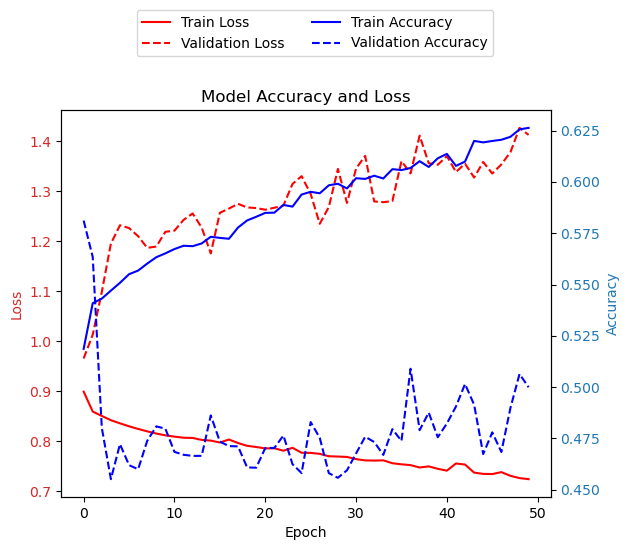

1778/1778 [==============================] - 6s 3ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 40, 'dropout': 0.1, 'accuracy': 0.4033656297807241, 'precision': 0.37459843339195076, 'recall': 0.3765797420912686, 'f1': 0.36183289393930423}
preprocessing...
Training...


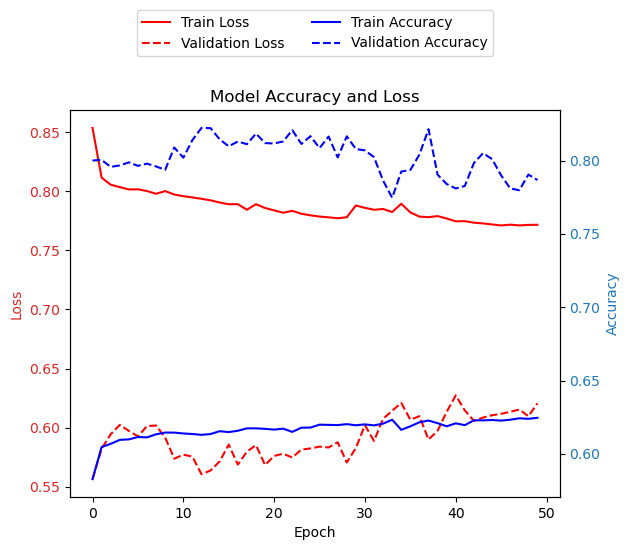

1743/1743 [==============================] - 10s 5ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 40, 'dropout': 0.1, 'accuracy': 0.7821899381221415, 'precision': 0.3511208323088046, 'recall': 0.3601208554770192, 'f1': 0.34726582469602724}
preprocessing...
Training...


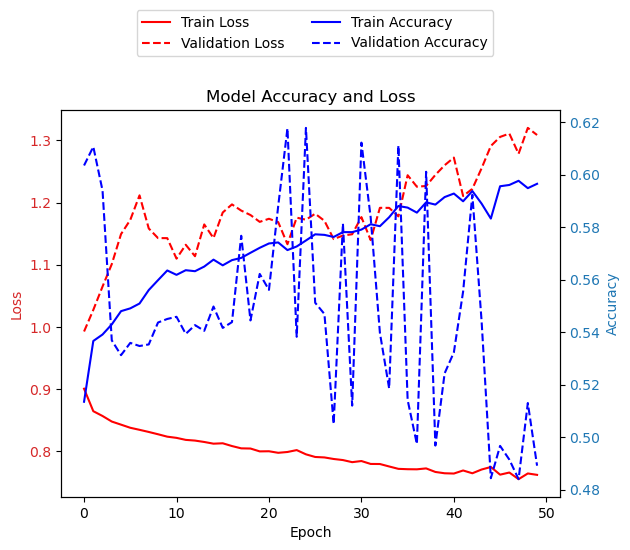

1778/1778 [==============================] - 6s 3ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 40, 'dropout': 0.4, 'accuracy': 0.4536214809474406, 'precision': 0.3661242820312369, 'recall': 0.3661505401484077, 'f1': 0.36605182012118337}
preprocessing...
Training...


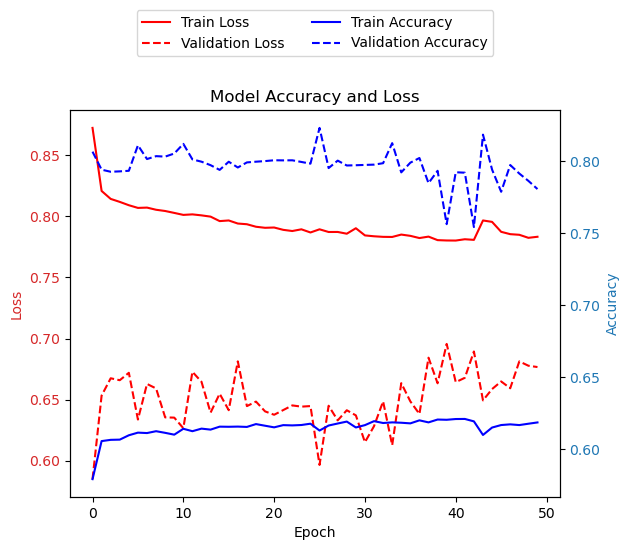

1743/1743 [==============================] - 9s 5ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 40, 'dropout': 0.4, 'accuracy': 0.7833916240695902, 'precision': 0.34892614308102776, 'recall': 0.35550436733808005, 'f1': 0.3444611548572769}
preprocessing...
Training...


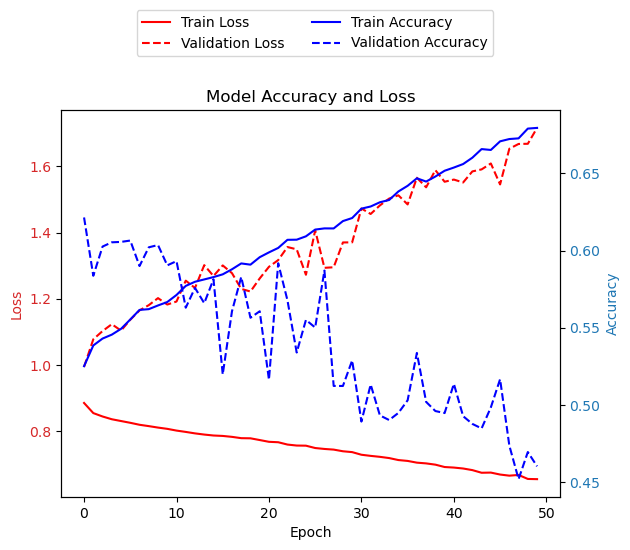

1778/1778 [==============================] - 8s 4ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 80, 'dropout': 0.1, 'accuracy': 0.43971232129982946, 'precision': 0.3781642476663793, 'recall': 0.3817090194252164, 'f1': 0.3749336205015037}
preprocessing...
Training...


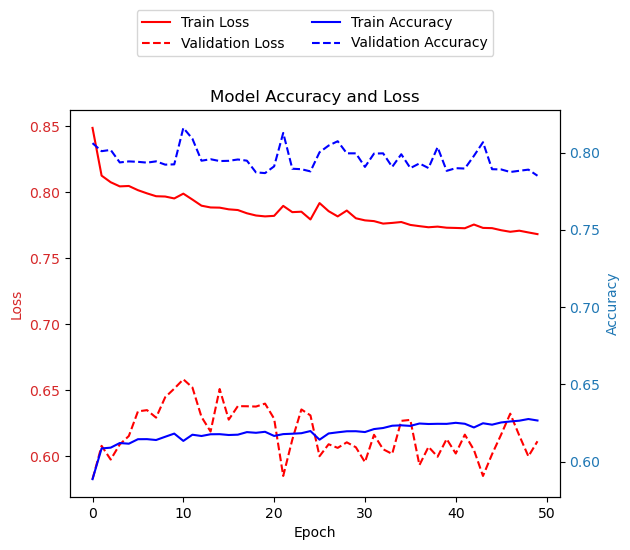

1743/1743 [==============================] - 14s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 80, 'dropout': 0.1, 'accuracy': 0.7963590709353421, 'precision': 0.342215061070368, 'recall': 0.34831541785032943, 'f1': 0.3373885039474617}
preprocessing...
Training...


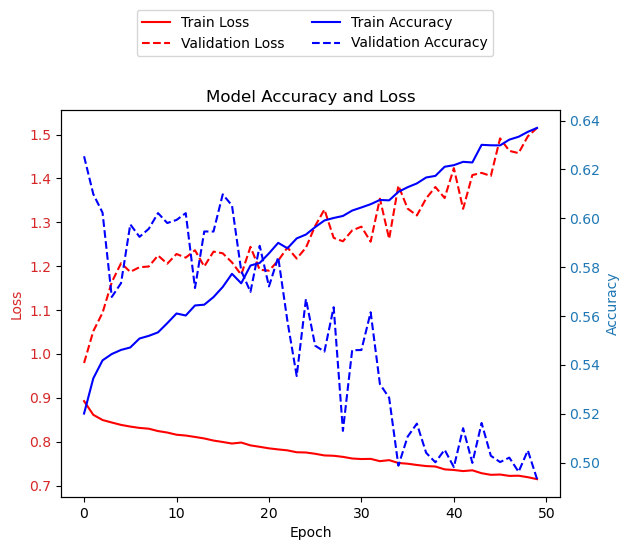

1778/1778 [==============================] - 9s 5ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 80, 'dropout': 0.4, 'accuracy': 0.3703775343332923, 'precision': 0.3393964084389967, 'recall': 0.3366499940218403, 'f1': 0.3283445941438836}
preprocessing...
Training...


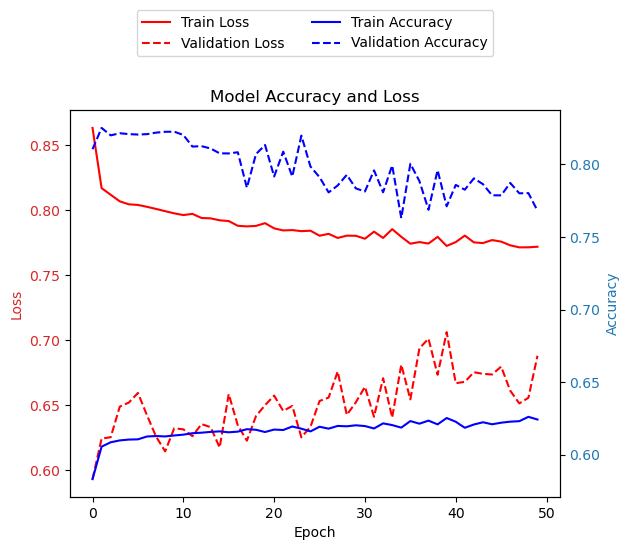

1743/1743 [==============================] - 15s 9ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 80, 'dropout': 0.4, 'accuracy': 0.7417810061877859, 'precision': 0.34797178915503313, 'recall': 0.35715474717321255, 'f1': 0.34324397549905833}
preprocessing...
Training...


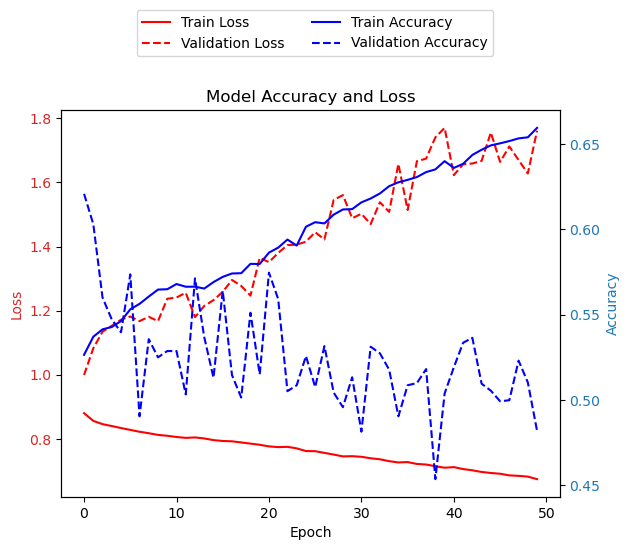

1778/1778 [==============================] - 10s 6ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 120, 'dropout': 0.1, 'accuracy': 0.33190314582637287, 'precision': 0.37524232559742954, 'recall': 0.3549747111781143, 'f1': 0.3131666556452685}
preprocessing...
Training...


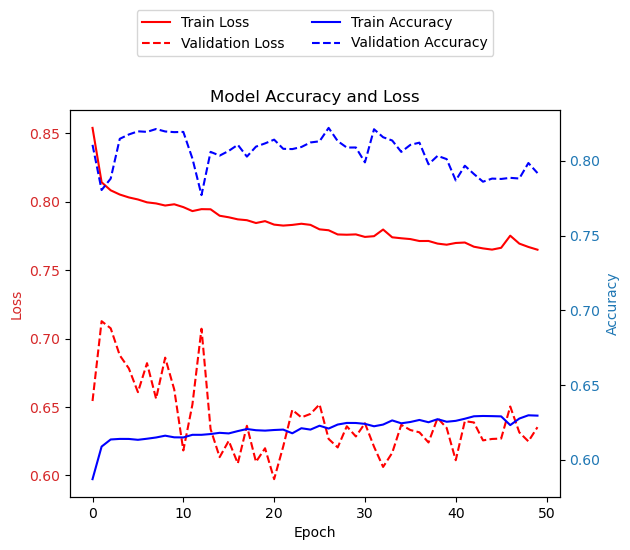

1743/1743 [==============================] - 20s 11ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 120, 'dropout': 0.1, 'accuracy': 0.7886646937494395, 'precision': 0.34168530242909007, 'recall': 0.35650607232535103, 'f1': 0.3388205272881381}
preprocessing...
Training...


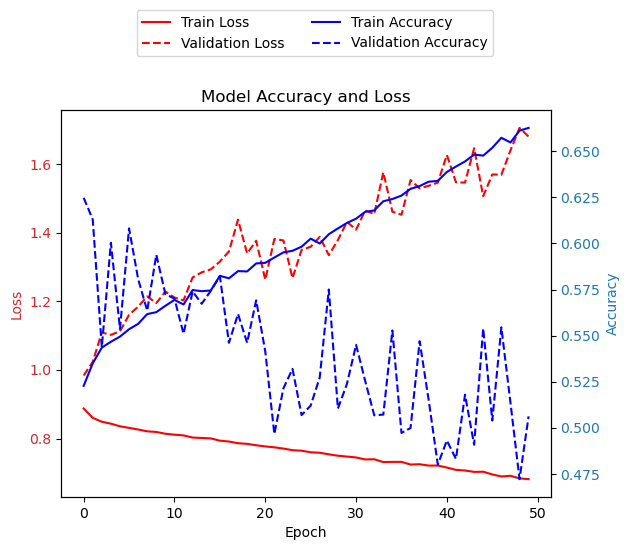

1778/1778 [==============================] - 10s 6ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 120, 'dropout': 0.4, 'accuracy': 0.39330742583833017, 'precision': 0.3632364677370812, 'recall': 0.36756312978698075, 'f1': 0.35229010911741704}
preprocessing...
Training...


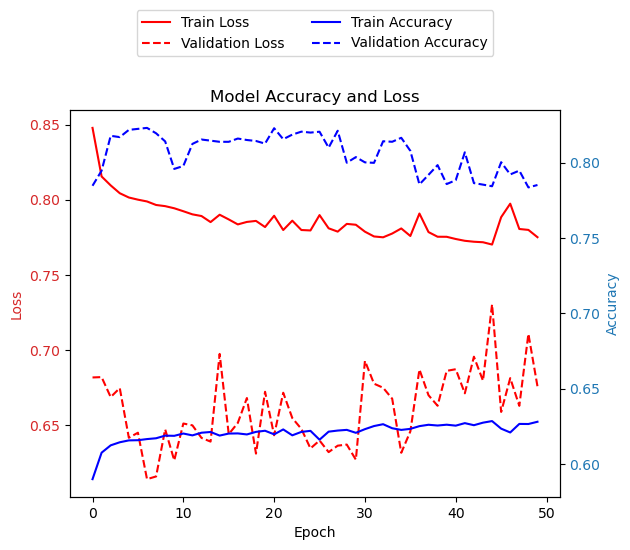

1743/1743 [==============================] - 20s 11ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adamw', 'cell_size': 120, 'dropout': 0.4, 'accuracy': 0.7843960182943234, 'precision': 0.3461726723626324, 'recall': 0.35667448736052626, 'f1': 0.3399292113659647}
preprocessing...
Training...


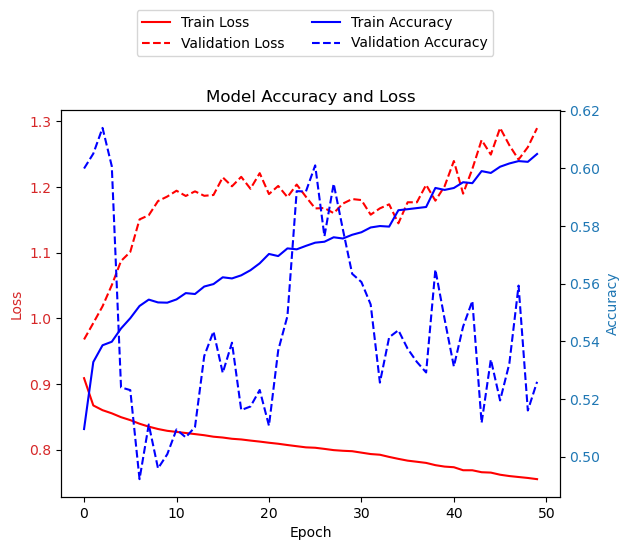

1778/1778 [==============================] - 6s 3ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 40, 'dropout': 0.1, 'accuracy': 0.4526367616803531, 'precision': 0.37071410076963024, 'recall': 0.38337465370264917, 'f1': 0.3549718940735865}
preprocessing...
Training...


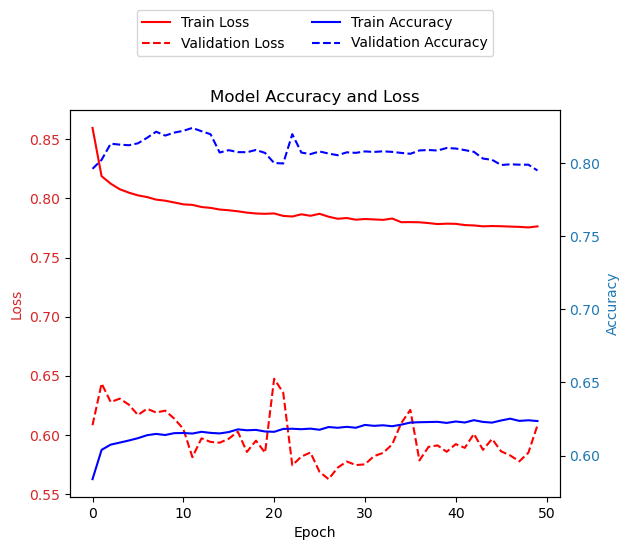

1743/1743 [==============================] - 11s 6ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 40, 'dropout': 0.1, 'accuracy': 0.798206438884405, 'precision': 0.34590900044895717, 'recall': 0.35563976084354976, 'f1': 0.3396073670031103}
preprocessing...
Training...


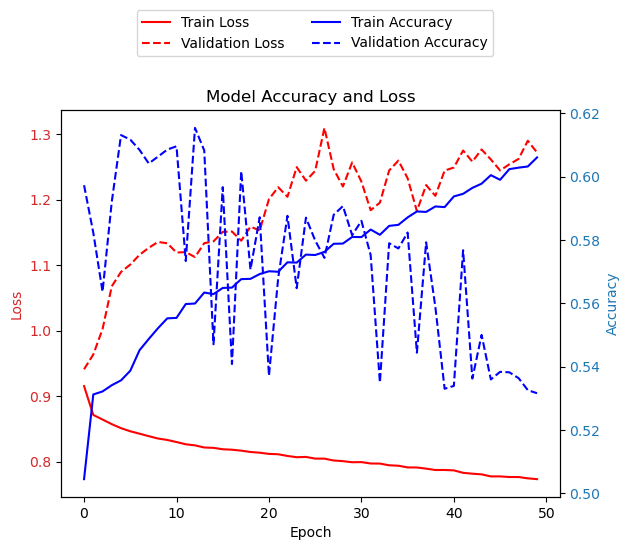

1778/1778 [==============================] - 6s 3ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 40, 'dropout': 0.4, 'accuracy': 0.40837714747929454, 'precision': 0.41026081041690493, 'recall': 0.40910385220960427, 'f1': 0.36022759188943326}
preprocessing...
Training...


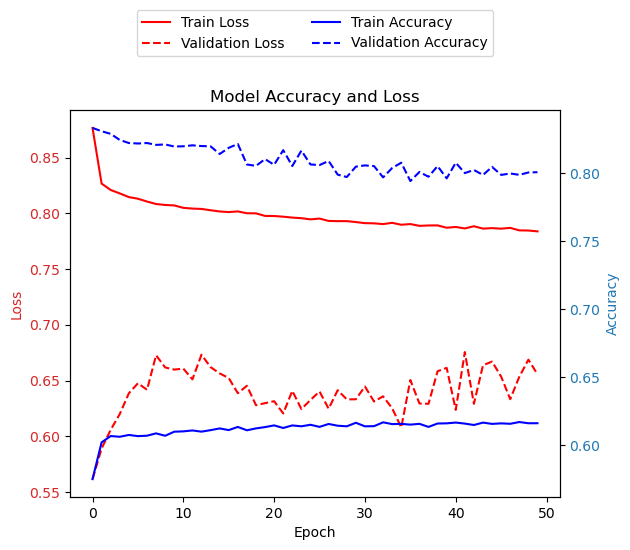

1743/1743 [==============================] - 11s 6ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 40, 'dropout': 0.4, 'accuracy': 0.7774908079992826, 'precision': 0.36891602940980955, 'recall': 0.37178068700442135, 'f1': 0.3467030080650584}
preprocessing...
Training...


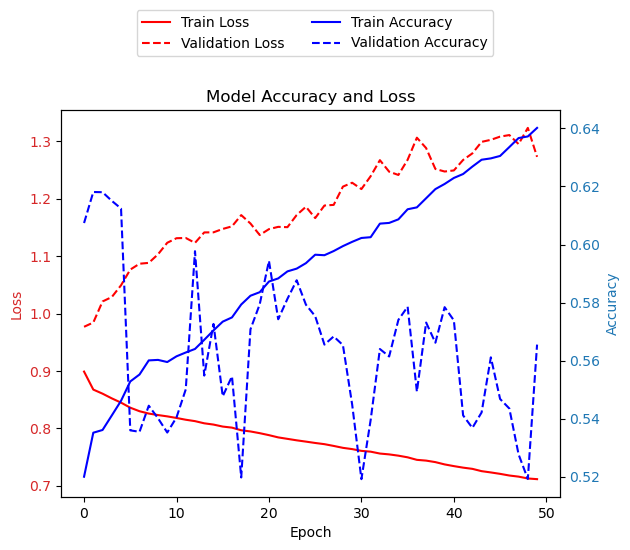

1778/1778 [==============================] - 9s 5ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 80, 'dropout': 0.1, 'accuracy': 0.41393377762928835, 'precision': 0.41431410177239303, 'recall': 0.40858557975926146, 'f1': 0.35496277411110655}
preprocessing...
Training...


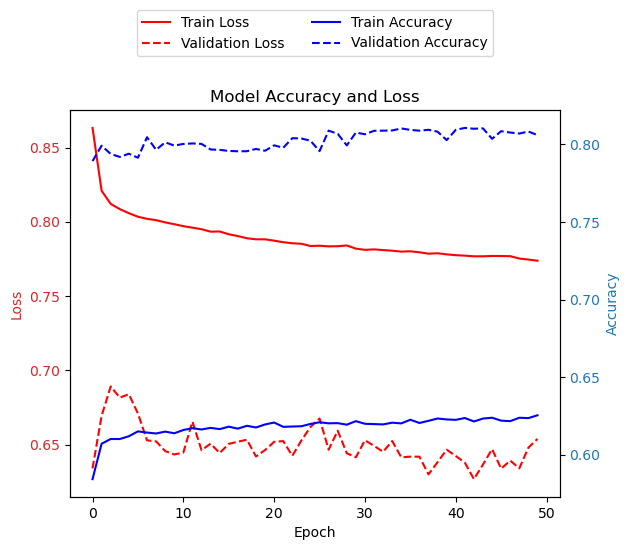

1743/1743 [==============================] - 15s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 80, 'dropout': 0.1, 'accuracy': 0.8098645861357726, 'precision': 0.35313687138706035, 'recall': 0.3649154744367837, 'f1': 0.3477107390869662}
preprocessing...
Training...


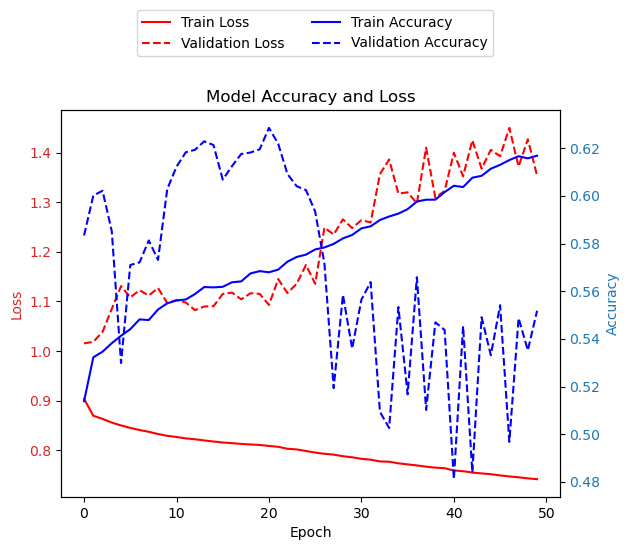

1778/1778 [==============================] - 8s 4ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 80, 'dropout': 0.4, 'accuracy': 0.41825950869542283, 'precision': 0.3785981506676499, 'recall': 0.37911806220313665, 'f1': 0.36165105244593215}
preprocessing...
Training...


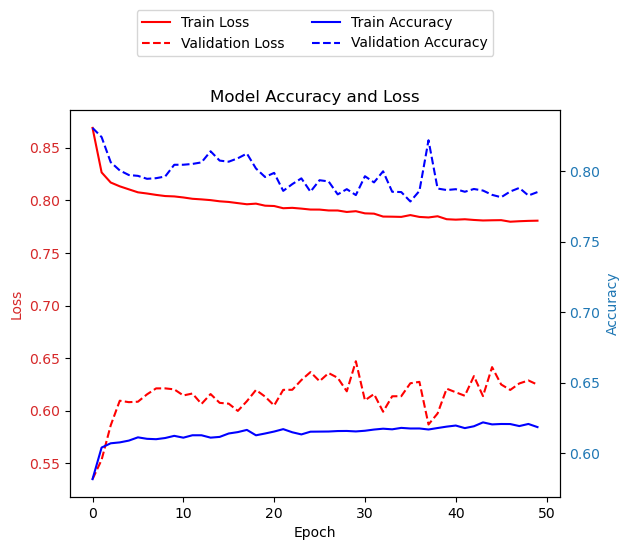

1743/1743 [==============================] - 15s 9ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 80, 'dropout': 0.4, 'accuracy': 0.7979015334947538, 'precision': 0.36324622038399884, 'recall': 0.3580091135889059, 'f1': 0.3515319249900344}
preprocessing...
Training...


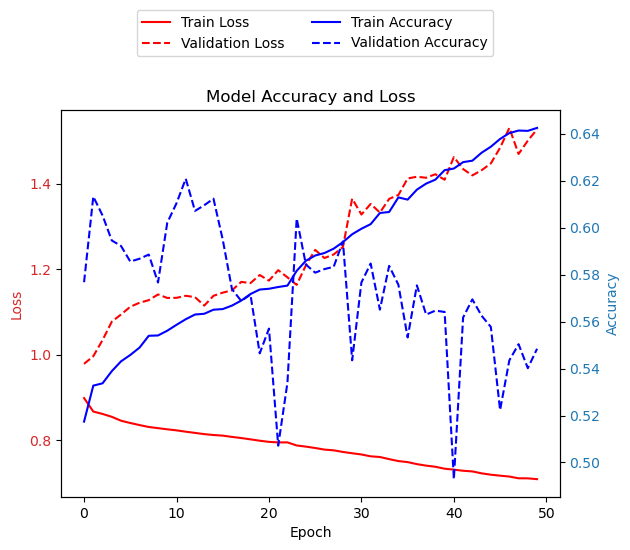

1778/1778 [==============================] - 11s 6ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 120, 'dropout': 0.1, 'accuracy': 0.459195695370061, 'precision': 0.41499152195208105, 'recall': 0.4196521376905094, 'f1': 0.39928645365761}
preprocessing...
Training...


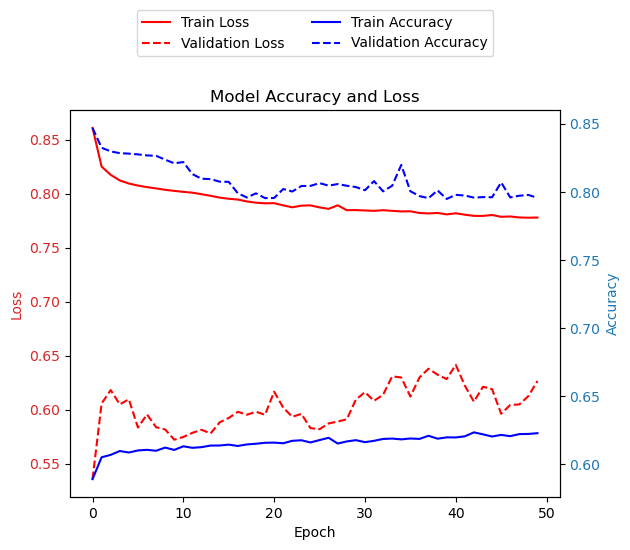

1743/1743 [==============================] - 22s 12ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 120, 'dropout': 0.1, 'accuracy': 0.8058111380145279, 'precision': 0.35142262249968725, 'recall': 0.363088621620411, 'f1': 0.34875441721201456}
preprocessing...
Training...


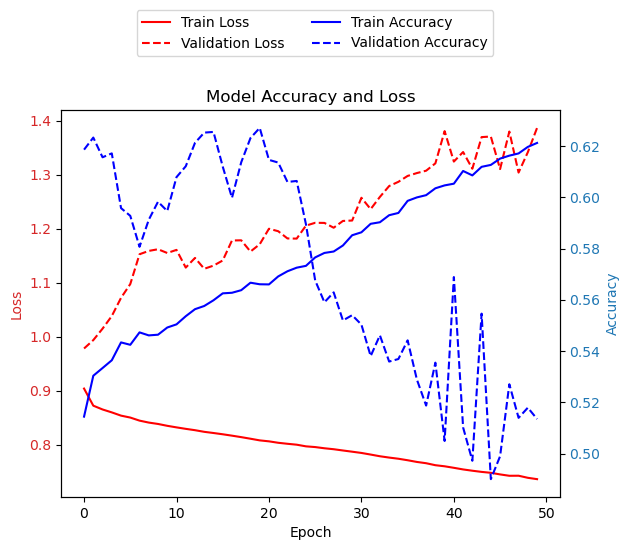

1778/1778 [==============================] - 11s 6ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 120, 'dropout': 0.4, 'accuracy': 0.37814978283423306, 'precision': 0.416642094340067, 'recall': 0.38008907162841893, 'f1': 0.3404088193692354}
preprocessing...
Training...


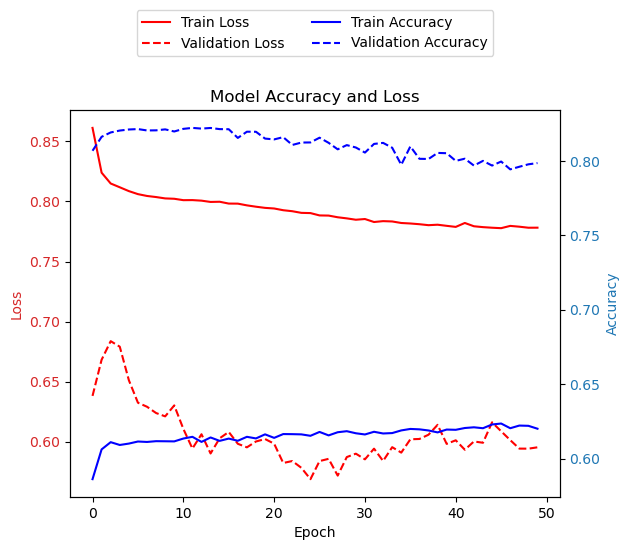

1743/1743 [==============================] - 21s 12ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'adadelta', 'cell_size': 120, 'dropout': 0.4, 'accuracy': 0.805380683346785, 'precision': 0.3469236518283329, 'recall': 0.35275648666692244, 'f1': 0.3395091330800146}
preprocessing...
Training...


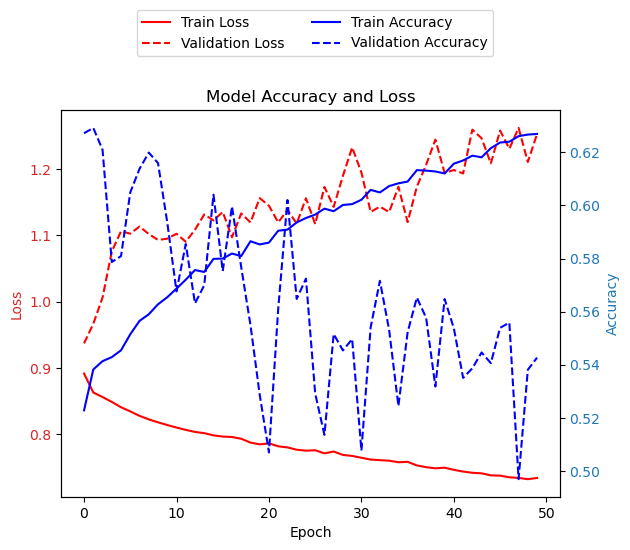

1778/1778 [==============================] - 6s 3ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 40, 'dropout': 0.1, 'accuracy': 0.5007121630413758, 'precision': 0.40360228799125847, 'recall': 0.4048795395691167, 'f1': 0.40395311856698707}
preprocessing...
Training...


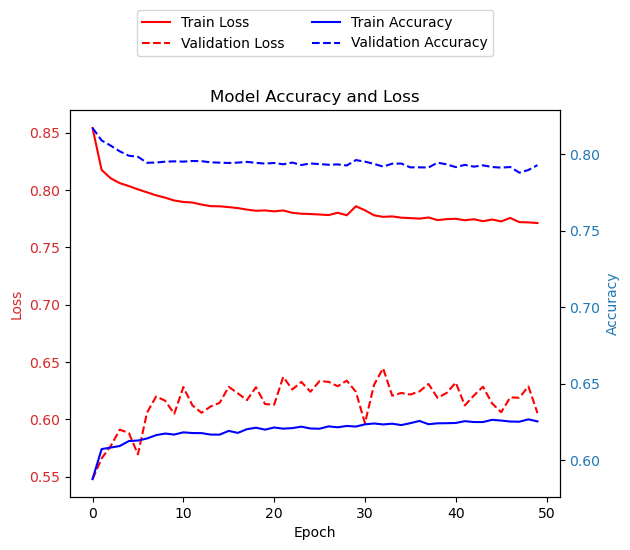

1743/1743 [==============================] - 10s 6ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 40, 'dropout': 0.1, 'accuracy': 0.8071563088512241, 'precision': 0.3667291423206604, 'recall': 0.36924426961428236, 'f1': 0.35692524835952577}
preprocessing...
Training...


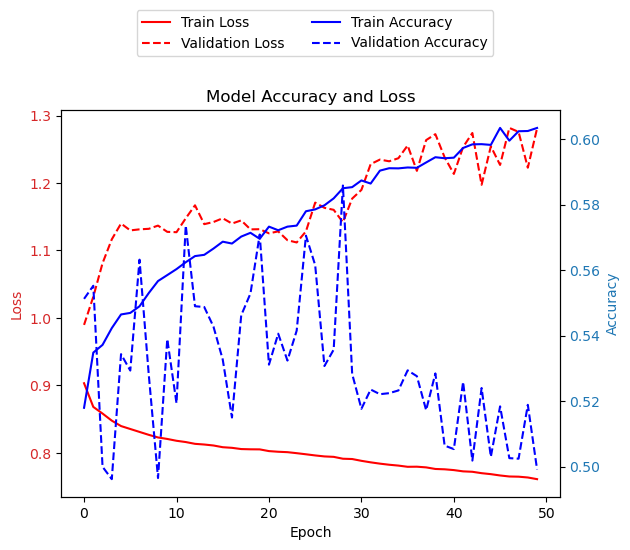

1778/1778 [==============================] - 6s 3ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 40, 'dropout': 0.4, 'accuracy': 0.42981237581107457, 'precision': 0.4027901442790924, 'recall': 0.4084301440670879, 'f1': 0.38752571618362514}
preprocessing...
Training...


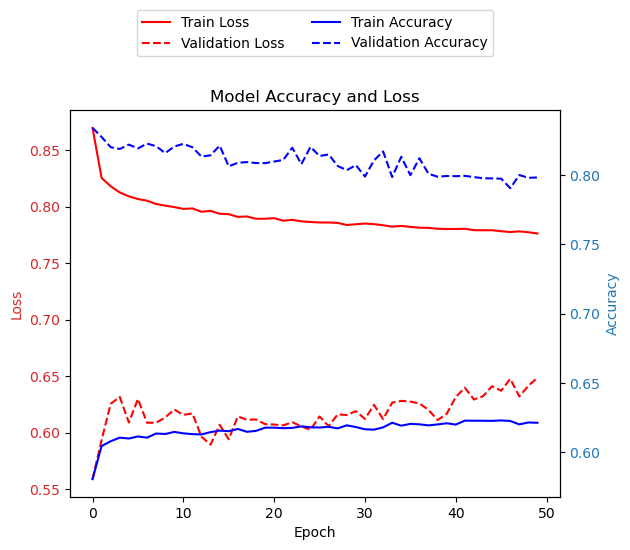

1743/1743 [==============================] - 10s 6ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 40, 'dropout': 0.4, 'accuracy': 0.7903506411980988, 'precision': 0.36282559331354247, 'recall': 0.37361492298237736, 'f1': 0.35051557123932514}
preprocessing...
Training...


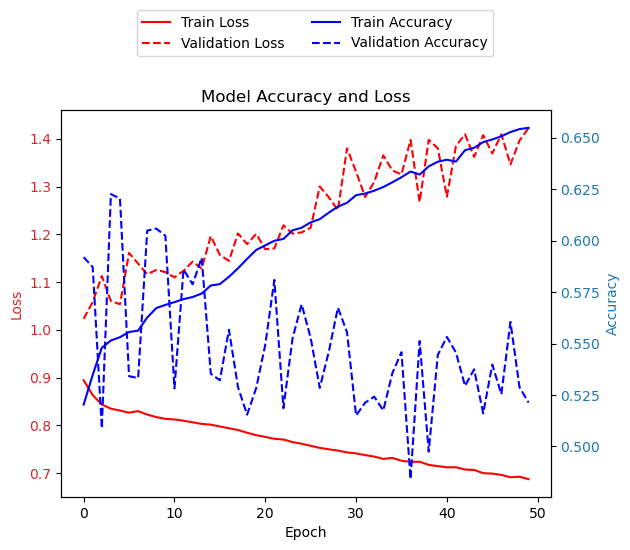

1778/1778 [==============================] - 10s 5ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 80, 'dropout': 0.1, 'accuracy': 0.4135820921767571, 'precision': 0.3913135695637094, 'recall': 0.3913366245888749, 'f1': 0.3774392275291229}
preprocessing...
Training...


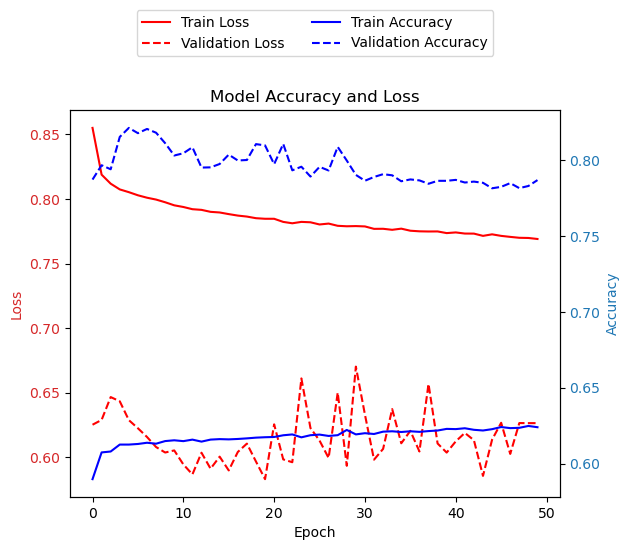

1743/1743 [==============================] - 17s 9ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 80, 'dropout': 0.1, 'accuracy': 0.7802708277284548, 'precision': 0.34219561389985437, 'recall': 0.35304833496457816, 'f1': 0.3375733270154879}
preprocessing...
Training...


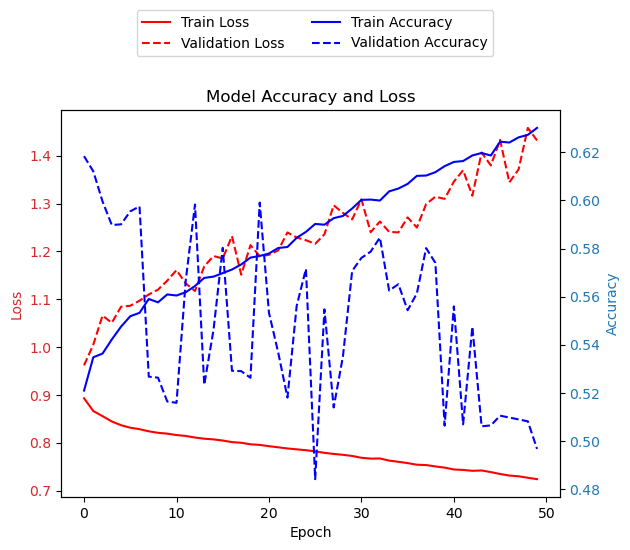

1778/1778 [==============================] - 11s 6ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 80, 'dropout': 0.4, 'accuracy': 0.41484815980586964, 'precision': 0.36027416569766896, 'recall': 0.36211132051939776, 'f1': 0.35765118545065105}
preprocessing...
Training...


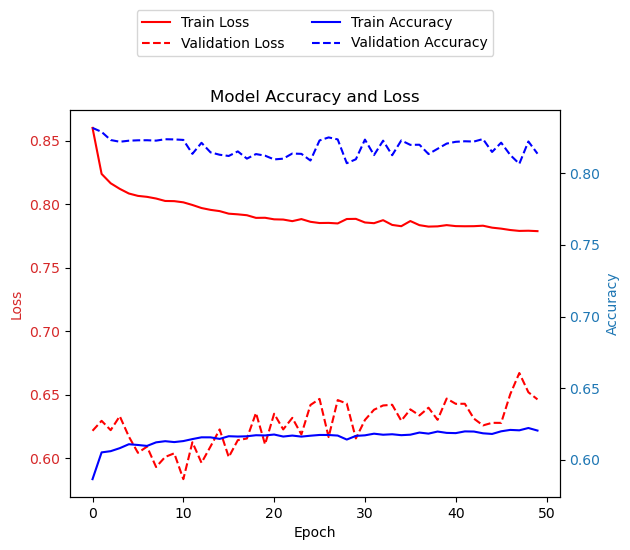

1743/1743 [==============================] - 18s 10ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 80, 'dropout': 0.4, 'accuracy': 0.7947089947089947, 'precision': 0.3556980652484034, 'recall': 0.36796669410404287, 'f1': 0.34479118181331936}
preprocessing...
Training...


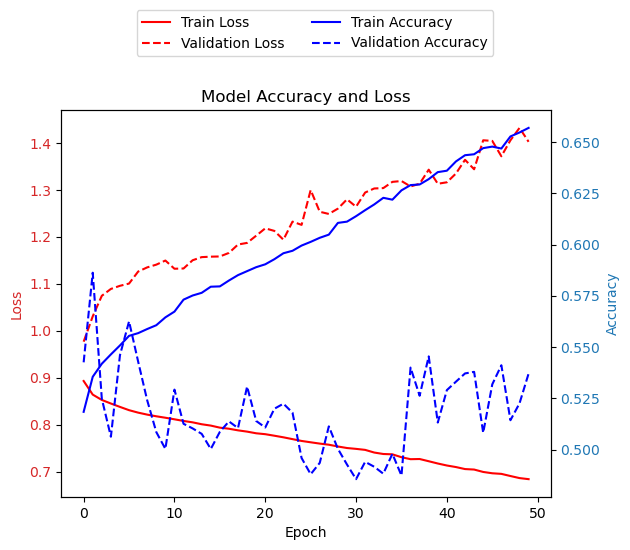

1778/1778 [==============================] - 12s 7ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 120, 'dropout': 0.1, 'accuracy': 0.47931210325484885, 'precision': 0.39005144598971125, 'recall': 0.3773369871213034, 'f1': 0.3781521163690806}
preprocessing...
Training...


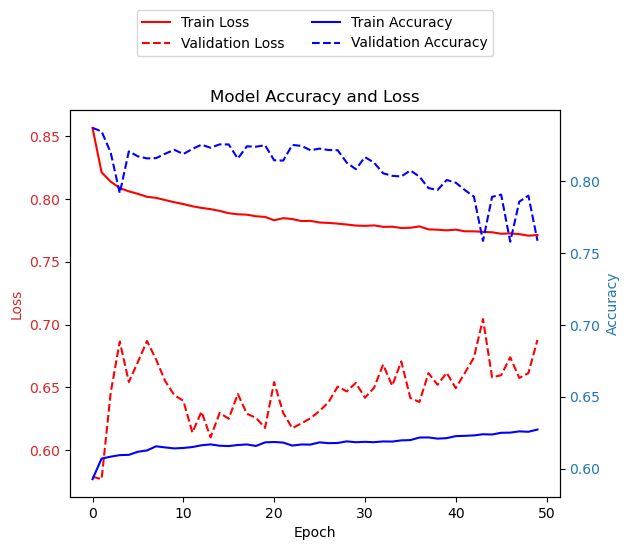

1743/1743 [==============================] - 23s 13ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 120, 'dropout': 0.1, 'accuracy': 0.7689713927002063, 'precision': 0.33584832339221765, 'recall': 0.34525404946514704, 'f1': 0.3278158093540053}
preprocessing...
Training...


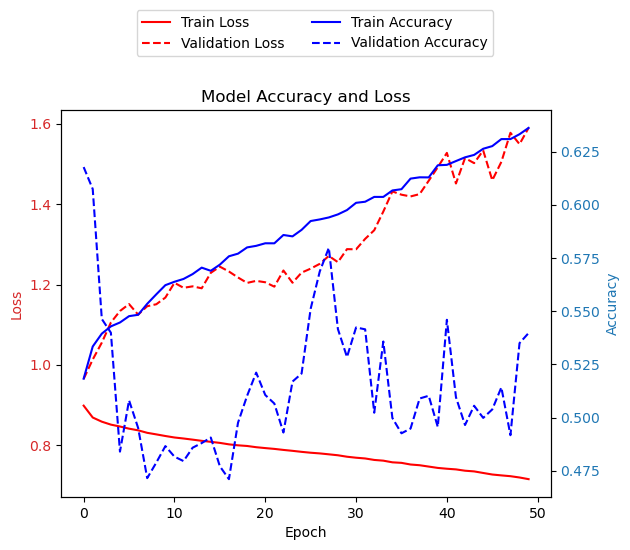

1778/1778 [==============================] - 13s 7ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 120, 'dropout': 0.4, 'accuracy': 0.39939158416712095, 'precision': 0.3551288776878867, 'recall': 0.36465996132597195, 'f1': 0.3380011911001255}
preprocessing...
Training...


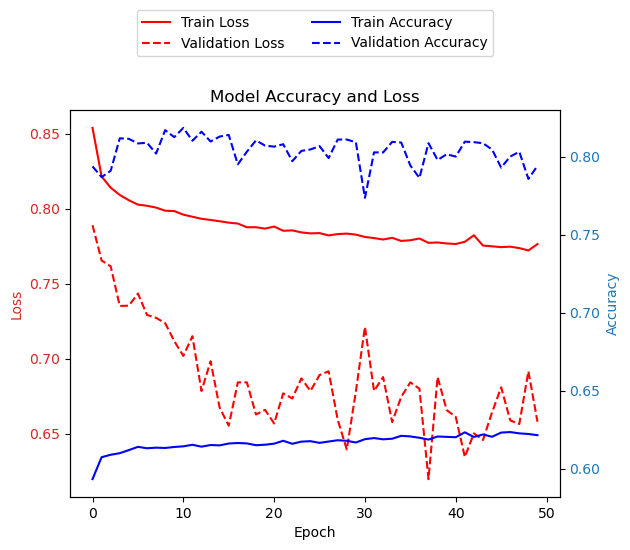

1743/1743 [==============================] - 24s 13ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 120, 'dropout': 0.4, 'accuracy': 0.7820823244552058, 'precision': 0.3577437247509976, 'recall': 0.36429040194712886, 'f1': 0.33876070679473874}


In [22]:
# grid search with train_v9 for optimizers and dropout rates
results_arr_10 = []
for optimizer in optimizers:
    for cell_size in cell_sizes:
        for dropout in dropout_list:
            for comb in input_output_combination: 
                try:
                    print('preprocessing...')
                    input_window = comb['input'] #***
                    output_window = comb['output'] #***

                    # Initialize empty lists to store aggregated inputs and targets
                    X_train,X_valid,X_test = [], [], []
                    Y_train,Y_valid,Y_test = [], [], []
                    # looping through symbols
                    symbols = filtered_df['crypto_symbol'].unique()
                    for s in symbols:
                        try:
                            sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                            sim_df.reset_index(inplace=True, drop=True)
                            
                            # First Loop: Calculate intervals for each column without modifying the DataFrame
                            intervals = {}
                            for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                                lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                                intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                                # getting the returns
                            reduced_df = sim_df.copy()
                            reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                            reduced_df = reduced_df[reduced_df['returns'].notna()]
                            reduced_df.reset_index(inplace=True, drop=True)

                            # Second Loop: Filter rows based on the pre-calculated intervals
                            for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                                lower_bound = intervals[column]['lower_bound']
                                upper_bound = intervals[column]['upper_bound']
                                # Apply filtering based on pre-calculated bounds
                                reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                            reduced_df.reset_index(inplace=True, drop=True)

                            # MinMax scaling
                            scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                            scaled_df = reduced_df.copy()
                            scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                            scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                            scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                            scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                            scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                            scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                            inputs_train, inputs_valid, inputs_test, targets_train, targets_valid, targets_test = pre.extract_valid_windows_v4(scaled_df,
                            'date', input_window, output_window, input_columns, ['lending_rate','borrowing_rate'],train_end_date="2023-07-01 00:00:00", valid_end_date="2024-01-25 00:00:00")

                            # Append results from the current DataFrame
                            X_train.append(inputs_train)
                            X_valid.append(inputs_valid)
                            X_test.append(inputs_test)
                            Y_train.append(targets_train)
                            Y_valid.append(targets_valid)
                            Y_test.append(targets_test)

                        # Handle any other exceptions
                        except Exception as e:
                            print(f"Unexpected error in symbol {s}: {e}")

                    # Concatenate all inputs and targets into single arrays
                    X_train = [arr for arr in X_train if len(arr) > 0]
                    X_valid = [arr for arr in X_valid if len(arr) > 0]
                    X_test = [arr for arr in X_test if len(arr) > 0]

                    Y_train = [arr for arr in Y_train if len(arr) > 0]
                    Y_valid = [arr for arr in Y_valid if len(arr) > 0]
                    Y_test = [arr for arr in Y_test if len(arr) > 0]

                    X_train  = np.concatenate(X_train, axis=0) if X_train else np.array([])
                    X_valid = np.concatenate(X_valid, axis=0) if X_valid else np.array([])
                    X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])

                    Y_train  = np.concatenate(Y_train, axis=0) if Y_train else np.array([])
                    Y_valid = np.concatenate(Y_valid, axis=0) if Y_valid else np.array([])
                    Y_test  = np.concatenate(Y_test, axis=0) if Y_test else np.array([])
                    # Lending rate
                    lending_rate_Y_train = Y_train[:, 0].reshape(Y_train.shape[0], 1) 
                    lending_rate_Y_valid = Y_valid[:, 0].reshape(Y_valid.shape[0], 1) 
                    lending_rate_Y_test = Y_test[:, 0].reshape(Y_test.shape[0], 1) 
                    # Borrowing rate
                    borrow_rate_Y_train = Y_train[:, 1].reshape(Y_train.shape[0], 1) 
                    borrow_rate_Y_valid = Y_valid[:, 1].reshape(Y_valid.shape[0], 1) 
                    borrow_rate_Y_test = Y_test[:, 1].reshape(Y_test.shape[0], 1) 


                    # Apply rebalancing
                    X_train, borrow_rate_Y_train = pre.rebalance_classes_general(X_train, borrow_rate_Y_train, balance_ratio=balancer)

                    print('Training...')
                    Y_test, y_pred = pre.train_v9(X_train,X_valid,X_test,borrow_rate_Y_train,borrow_rate_Y_valid,borrow_rate_Y_test, details=True,epochs=epoch_num, 
                                                  batch_size=bacth_size, cell_size=cell_size, dropout_rate=dropout, optimizer_name=optimizer)
                    
                    accuracy, precision, recall, f1 = pre.classification_metrics(Y_test, y_pred, printed = False)

                    total_windows = Y_test.shape[0]
                        
                    new_row = {
                        'columns': f'{input_columns}',
                        'total_test_windows':total_windows,
                        'input_window':input_window,
                        'output_window':output_window, 
                        'outlier_threshold':outlier_threshold,
                        'optimizer':optimizer,
                        'cell_size':cell_size,
                        'dropout':dropout, 
                        'accuracy':accuracy, 
                        'precision':precision, 
                        'recall':recall, 
                        'f1':f1
                    }
                    results_arr_10.append(new_row)
                    print(new_row)
                    
                except Exception as e:
                    print(f"Error occurred with {input_columns}")
                    print(f"Exception details: {e}")

results = pd.DataFrame(results_arr_10)

In [23]:
results.to_csv('optimizers_dropouts.csv')
results

columns  total_test_windows  \
0   ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
1   ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
2   ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
3   ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
4   ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
5   ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
6   ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
7   ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
8   ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
9   ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
10  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
11  ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
12  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
13  ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
14  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
15  ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
16  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
17  ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
18  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
19  ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
20  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
21  ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
22  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
23  ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
24  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
25  ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
26  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
27  ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
28  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
29  ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
30  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
31  ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
32  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
33  ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
34  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
35  ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   

    input_window  output_window outlier_threshold optimizer  cell_size  \
0             48             48            remove     adamw         40   
1             96              8            remove     adamw         40   
2             48             48            remove     adamw         40   
3             96              8            remove     adamw         40   
4             48             48            remove     adamw         80   
5             96              8            remove     adamw         80   
6             48             48            remove     adamw         80   
7             96              8            remove     adamw         80   
8             48             48            remove     adamw        120   
9             96              8            remove     adamw        120   
10            48             48            remove     adamw        120   
11            96              8            remove     adamw        120   
12            48             48            remove  adadelta         40   
13            96              8            remove  adadelta         40   
14            48             48            remove  adadelta         40   
15          

### Best result is for rmsprop , with 40 cell-size , and 0.1 dropout rate, this brings up the question that does it help to reduce the cell size and dropout more.

In [24]:
input_columns = ['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention','returns', 'volume'] 
input_output_combination = [
     {'input':48, 'output':48},
]
outlier_threshold = 'remove'
epoch_num = 50
bacth_size = 200
balancer = 2
dropout_list = [0.02, 0.05, 0.1]
cell_sizes = [10, 20, 40]
optimizers = ['rmsprop']

preprocessing...
Training...


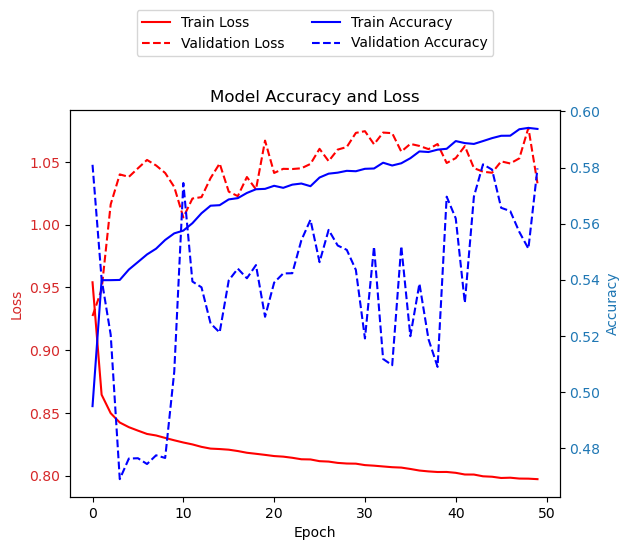

1778/1778 [==============================] - 4s 2ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 10, 'dropout': 0.02, 'accuracy': 0.3941163023791521, 'precision': 0.37582346208809886, 'recall': 0.3827296304483638, 'f1': 0.35576121283766243}
preprocessing...
Training...


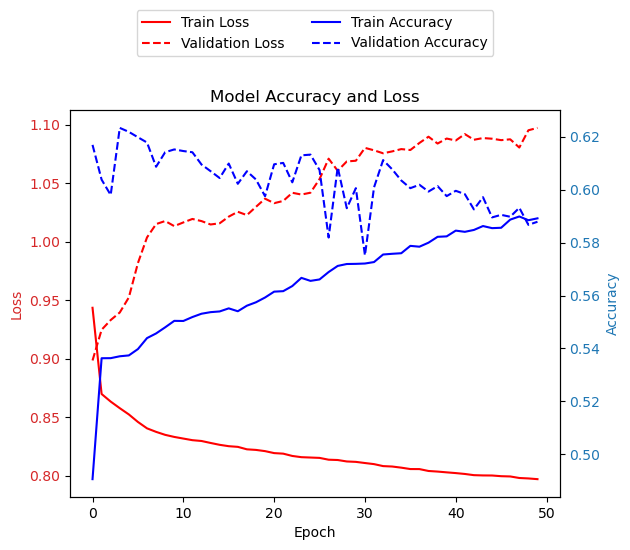

1778/1778 [==============================] - 4s 2ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 10, 'dropout': 0.05, 'accuracy': 0.4830575533243067, 'precision': 0.3918804430741454, 'recall': 0.39146258315207016, 'f1': 0.3856350983123573}
preprocessing...
Training...


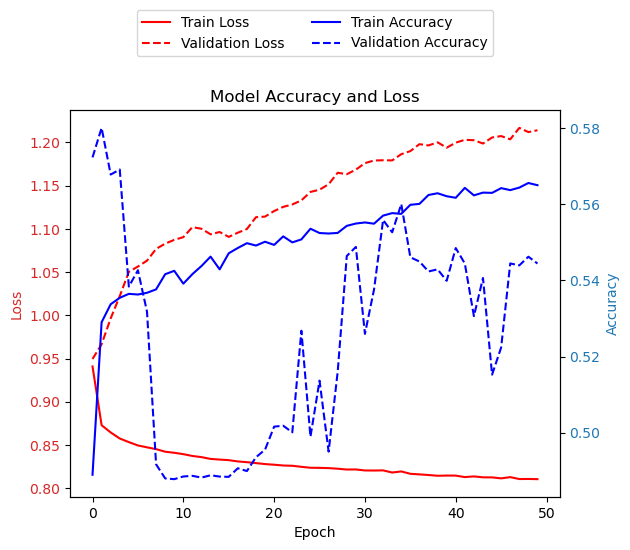

1778/1778 [==============================] - 4s 2ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 10, 'dropout': 0.1, 'accuracy': 0.28351122755807207, 'precision': 0.37169310057965105, 'recall': 0.35121483133758585, 'f1': 0.2680519726545256}
preprocessing...
Training...


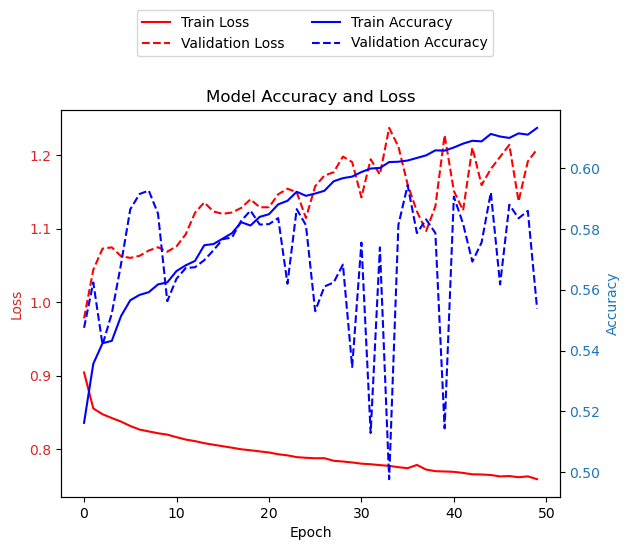

1778/1778 [==============================] - 5s 2ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 20, 'dropout': 0.02, 'accuracy': 0.47018586576166277, 'precision': 0.39478434791854466, 'recall': 0.3949016778475612, 'f1': 0.3922655001000786}
preprocessing...
Training...


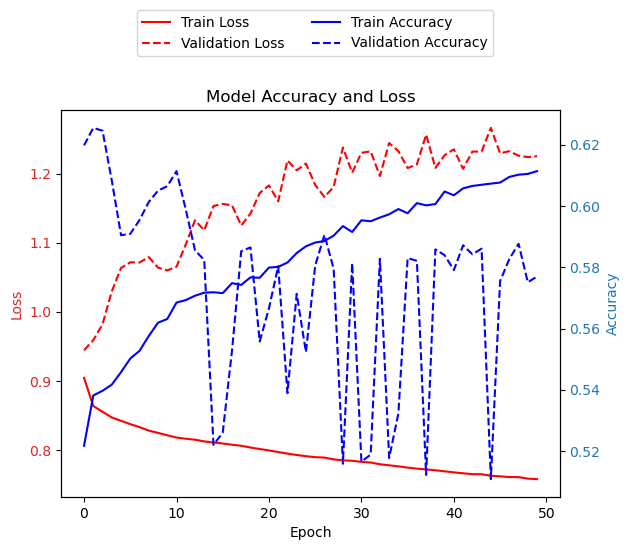

1778/1778 [==============================] - 5s 2ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 20, 'dropout': 0.05, 'accuracy': 0.37693646802300024, 'precision': 0.38808649334926787, 'recall': 0.37422242836177383, 'f1': 0.3478233144826432}
preprocessing...
Training...


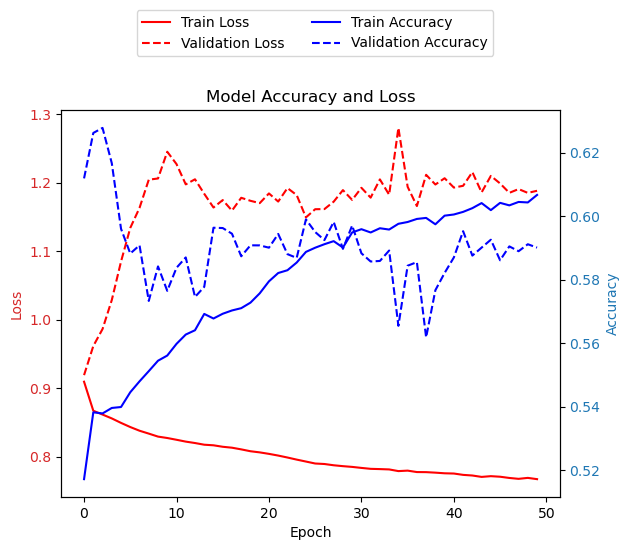

1778/1778 [==============================] - 5s 2ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 20, 'dropout': 0.1, 'accuracy': 0.35423517206210764, 'precision': 0.4002515143848393, 'recall': 0.40128715096504575, 'f1': 0.3519741295657208}
preprocessing...
Training...


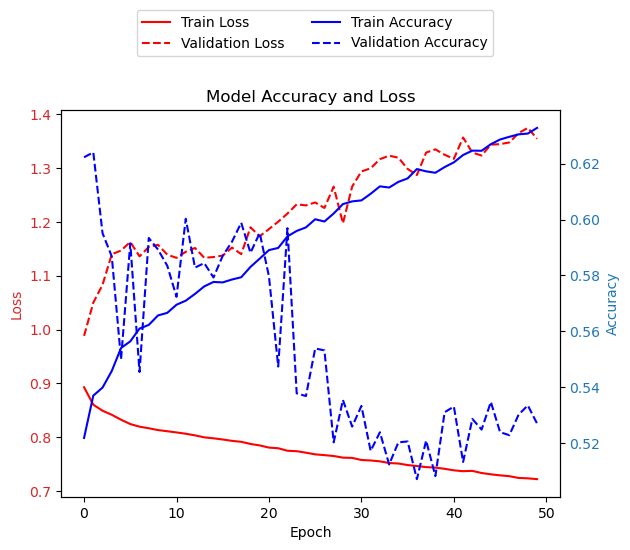

1778/1778 [==============================] - 6s 3ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 40, 'dropout': 0.02, 'accuracy': 0.44085529902055604, 'precision': 0.3758354892587661, 'recall': 0.3763068342445049, 'f1': 0.3723803900229293}
preprocessing...
Training...


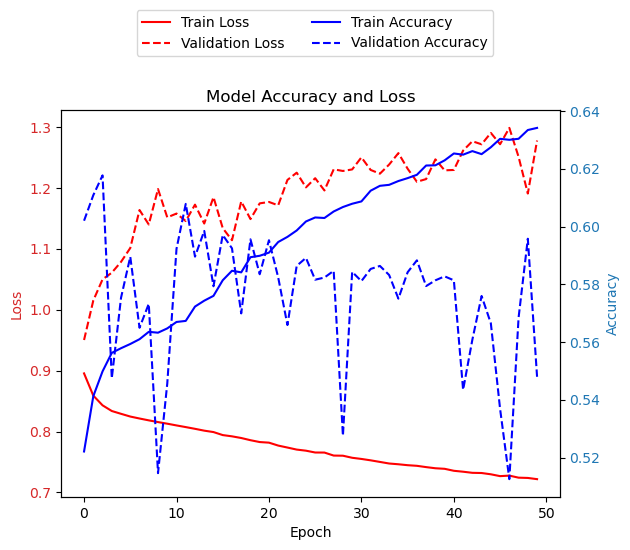

1778/1778 [==============================] - 6s 3ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 40, 'dropout': 0.05, 'accuracy': 0.4194024864161494, 'precision': 0.3868556279387331, 'recall': 0.39182504897577886, 'f1': 0.379301935779025}
preprocessing...
Training...


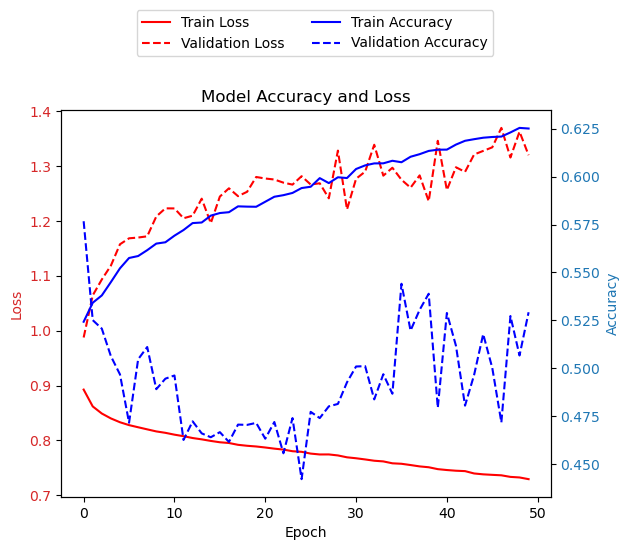

1778/1778 [==============================] - 6s 3ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 40, 'dropout': 0.1, 'accuracy': 0.39932124707661465, 'precision': 0.3966335079388259, 'recall': 0.39938846212669893, 'f1': 0.3618293213372831}


In [25]:
# grid search with train_v9 for optimizers and dropout rates
results_arr_11 = []
for optimizer in optimizers:
    for cell_size in cell_sizes:
        for dropout in dropout_list:
            for comb in input_output_combination: 
                try:
                    print('preprocessing...')
                    input_window = comb['input'] #***
                    output_window = comb['output'] #***

                    # Initialize empty lists to store aggregated inputs and targets
                    X_train,X_valid,X_test = [], [], []
                    Y_train,Y_valid,Y_test = [], [], []
                    # looping through symbols
                    symbols = filtered_df['crypto_symbol'].unique()
                    for s in symbols:
                        try:
                            sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                            sim_df.reset_index(inplace=True, drop=True)
                            
                            # First Loop: Calculate intervals for each column without modifying the DataFrame
                            intervals = {}
                            for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                                lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                                intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                                # getting the returns
                            reduced_df = sim_df.copy()
                            reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                            reduced_df = reduced_df[reduced_df['returns'].notna()]
                            reduced_df.reset_index(inplace=True, drop=True)

                            # Second Loop: Filter rows based on the pre-calculated intervals
                            for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                                lower_bound = intervals[column]['lower_bound']
                                upper_bound = intervals[column]['upper_bound']
                                # Apply filtering based on pre-calculated bounds
                                reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                            reduced_df.reset_index(inplace=True, drop=True)

                            # MinMax scaling
                            scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                            scaled_df = reduced_df.copy()
                            scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                            scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                            scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                            scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                            scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                            scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                            inputs_train, inputs_valid, inputs_test, targets_train, targets_valid, targets_test = pre.extract_valid_windows_v4(scaled_df,
                            'date', input_window, output_window, input_columns, ['lending_rate','borrowing_rate'],train_end_date="2023-07-01 00:00:00", valid_end_date="2024-01-25 00:00:00")

                            # Append results from the current DataFrame
                            X_train.append(inputs_train)
                            X_valid.append(inputs_valid)
                            X_test.append(inputs_test)
                            Y_train.append(targets_train)
                            Y_valid.append(targets_valid)
                            Y_test.append(targets_test)

                        # Handle any other exceptions
                        except Exception as e:
                            print(f"Unexpected error in symbol {s}: {e}")

                    # Concatenate all inputs and targets into single arrays
                    X_train = [arr for arr in X_train if len(arr) > 0]
                    X_valid = [arr for arr in X_valid if len(arr) > 0]
                    X_test = [arr for arr in X_test if len(arr) > 0]

                    Y_train = [arr for arr in Y_train if len(arr) > 0]
                    Y_valid = [arr for arr in Y_valid if len(arr) > 0]
                    Y_test = [arr for arr in Y_test if len(arr) > 0]

                    X_train  = np.concatenate(X_train, axis=0) if X_train else np.array([])
                    X_valid = np.concatenate(X_valid, axis=0) if X_valid else np.array([])
                    X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])

                    Y_train  = np.concatenate(Y_train, axis=0) if Y_train else np.array([])
                    Y_valid = np.concatenate(Y_valid, axis=0) if Y_valid else np.array([])
                    Y_test  = np.concatenate(Y_test, axis=0) if Y_test else np.array([])
                    # Lending rate
                    lending_rate_Y_train = Y_train[:, 0].reshape(Y_train.shape[0], 1) 
                    lending_rate_Y_valid = Y_valid[:, 0].reshape(Y_valid.shape[0], 1) 
                    lending_rate_Y_test = Y_test[:, 0].reshape(Y_test.shape[0], 1) 
                    # Borrowing rate
                    borrow_rate_Y_train = Y_train[:, 1].reshape(Y_train.shape[0], 1) 
                    borrow_rate_Y_valid = Y_valid[:, 1].reshape(Y_valid.shape[0], 1) 
                    borrow_rate_Y_test = Y_test[:, 1].reshape(Y_test.shape[0], 1) 


                    # Apply rebalancing
                    X_train, borrow_rate_Y_train = pre.rebalance_classes_general(X_train, borrow_rate_Y_train, balance_ratio=balancer)


                    print('Training...')
                    Y_test, y_pred = pre.train_v9(X_train,X_valid,X_test,borrow_rate_Y_train,borrow_rate_Y_valid,borrow_rate_Y_test, details=True,epochs=epoch_num, 
                                                  batch_size=bacth_size, cell_size=cell_size, dropout_rate=dropout, optimizer_name=optimizer)
                    
                    accuracy, precision, recall, f1 = pre.classification_metrics(Y_test, y_pred, printed = False)

                    total_windows = Y_test.shape[0]
                        
                    new_row = {
                        'columns': f'{input_columns}',
                        'total_test_windows':total_windows,
                        'input_window':input_window,
                        'output_window':output_window, 
                        'outlier_threshold':outlier_threshold,
                        'optimizer':optimizer,
                        'cell_size':cell_size,
                        'dropout':dropout, 
                        'accuracy':accuracy, 
                        'precision':precision, 
                        'recall':recall, 
                        'f1':f1
                    }
                    results_arr_11.append(new_row)
                    print(new_row)
                    
                except Exception as e:
                    print(f"Error occurred with {input_columns}")
                    print(f"Exception details: {e}")

results = pd.DataFrame(results_arr_11)

In [26]:
results.to_csv('rms_prop_metrics.csv')
results

columns  total_test_windows  \
0  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
1  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
2  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
3  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
4  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
5  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
6  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
7  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
8  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   

   input_window  output_window outlier_threshold optimizer  cell_size  \
0            48             48            remove   rmsprop         10   
1            48             48            remove   rmsprop         10   
2            48             48            remove   rmsprop         10   
3            48             48            remove   rmsprop         20   
4            48             48            remove   rmsprop         20   
5            48             48            remove   rmsprop         20   
6            48             48            remove   rmsprop         40   
7            48             48            remove   rmsprop         40   
8            48             48            remove   rmsprop         40   

   dropout  accuracy  precision    recall        f1  
0     0.02  0.394116   0.375823  0.382730  0.355761  
1     0.05  0.483058   0.391880  0.391463  0.385635  
2     0.10  0.283511   0.371693  0.351215  0.268052  
3     0.02  0.470186   0.394784  0.394902  0.392266  
4     0.05  0.376936   0.388086  0.374222  0.347823  
5     0.10  0.354235   0.400252  0.401287  0.351974  
6     0.02  0.440855   0.375835  0.376307  0.372380  
7     0.05  0.419402   0.386856  0.391825  0.379302  
8     0.10  0.399321   0.396634  0.399388  0.361829

### Smaller dropouts and smaller window sizes tend to perform better


In [27]:
# lets try rmsprop without dropouts
input_columns = ['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention','returns', 'volume'] 
input_output_combination = [
     {'input':48, 'output':48},
     {'input':96, 'output':8},
]
outlier_threshold = 'remove'
epoch_num = 50
bacth_size = 200
balancer = 2
dropout_list = [0, 0.02, 0.05]
cell_sizes = [5, 10]
optimizers = ['rmsprop']

preprocessing...
Training...


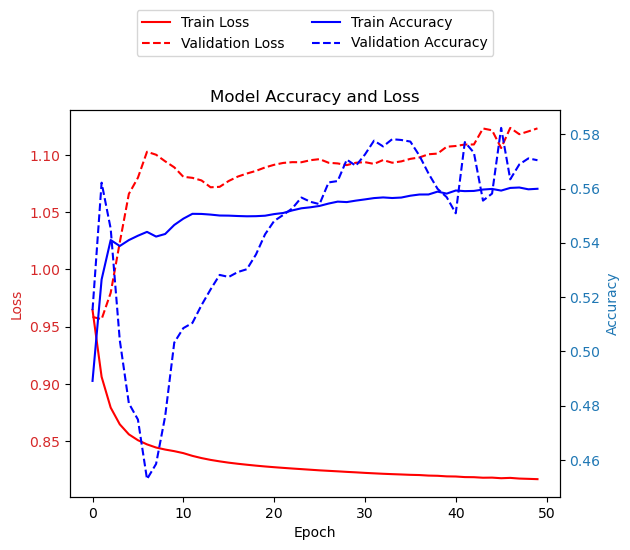

1778/1778 [==============================] - 4s 2ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 5, 'dropout': 0, 'accuracy': 0.4070055742144226, 'precision': 0.3765668576869165, 'recall': 0.37851509595537197, 'f1': 0.3471411192987565}
preprocessing...
Training...


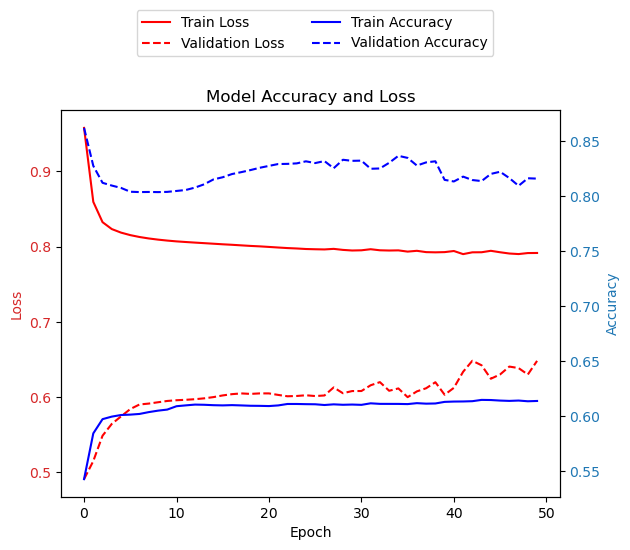

1743/1743 [==============================] - 7s 4ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 5, 'dropout': 0, 'accuracy': 0.8113532418617164, 'precision': 0.3660263076723275, 'recall': 0.3760884020805649, 'f1': 0.36097696747688784}
preprocessing...
Training...


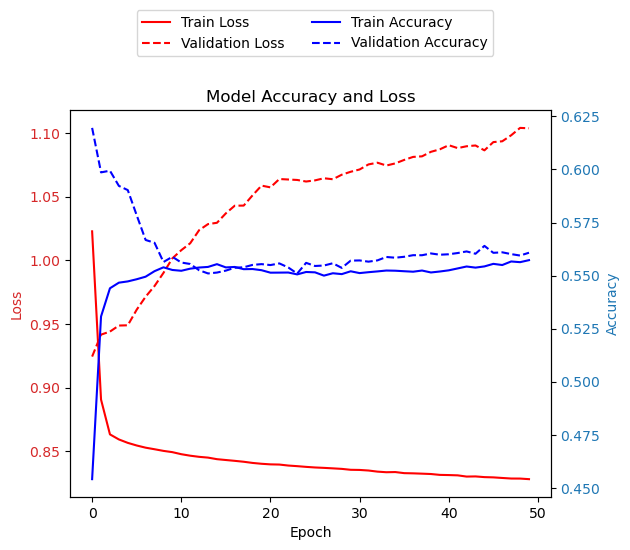

1778/1778 [==============================] - 4s 2ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 5, 'dropout': 0.02, 'accuracy': 0.3043661748931755, 'precision': 0.3786086656841589, 'recall': 0.3484505943498813, 'f1': 0.2932895136964437}
preprocessing...
Training...


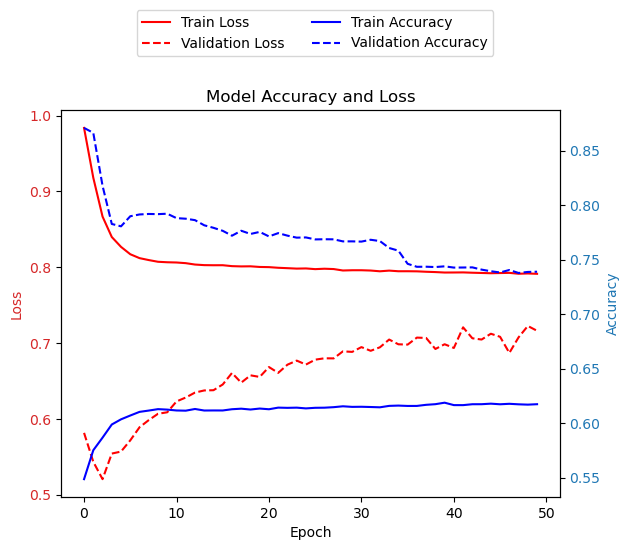

1743/1743 [==============================] - 6s 3ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 5, 'dropout': 0.02, 'accuracy': 0.4077661196305264, 'precision': 0.371328221716355, 'recall': 0.3854889455613975, 'f1': 0.27575135954673463}
preprocessing...
Training...


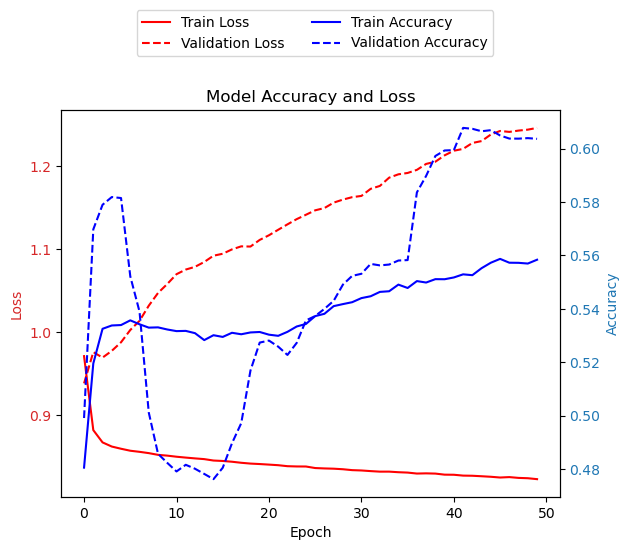

1778/1778 [==============================] - 4s 2ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 5, 'dropout': 0.05, 'accuracy': 0.27617858587279537, 'precision': 0.3277265058020885, 'recall': 0.3224030807557233, 'f1': 0.23098227860693418}
preprocessing...
Training...


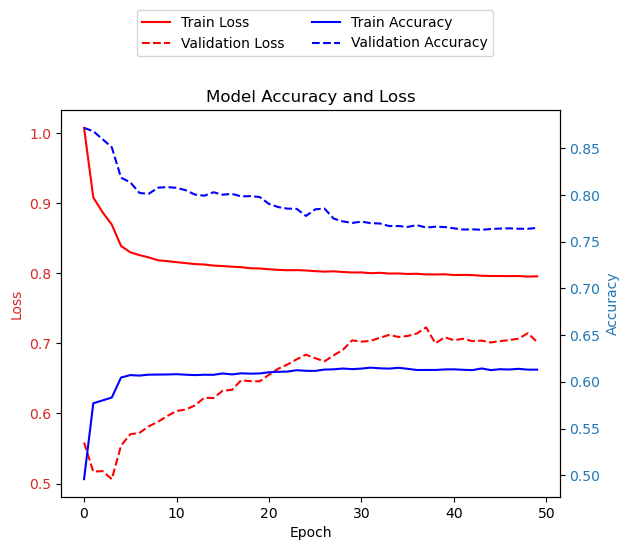

1743/1743 [==============================] - 7s 4ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 5, 'dropout': 0.05, 'accuracy': 0.7002062595282934, 'precision': 0.3277049812393424, 'recall': 0.33191723662838, 'f1': 0.30882756149954516}
preprocessing...
Training...


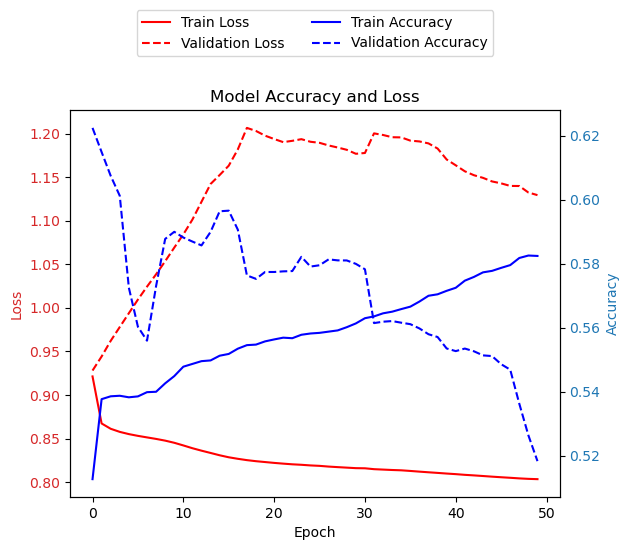

1778/1778 [==============================] - 5s 2ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 10, 'dropout': 0, 'accuracy': 0.3339429214510542, 'precision': 0.33183576043972346, 'recall': 0.3247439135774349, 'f1': 0.30416392774914053}
preprocessing...
Training...


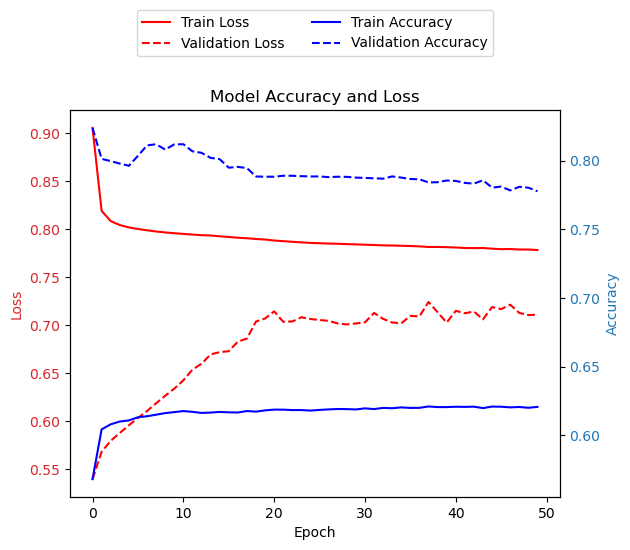

1743/1743 [==============================] - 7s 3ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 10, 'dropout': 0, 'accuracy': 0.6954533225719667, 'precision': 0.3413919522128914, 'recall': 0.35687088430116337, 'f1': 0.3286531087457598}
preprocessing...
Training...


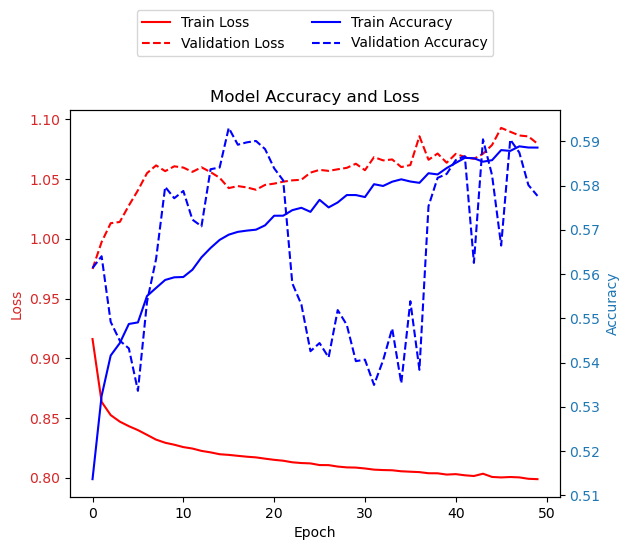

1778/1778 [==============================] - 4s 2ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 10, 'dropout': 0.02, 'accuracy': 0.3865550651497301, 'precision': 0.39207523059025, 'recall': 0.3746733527287949, 'f1': 0.3551122731785437}
preprocessing...
Training...


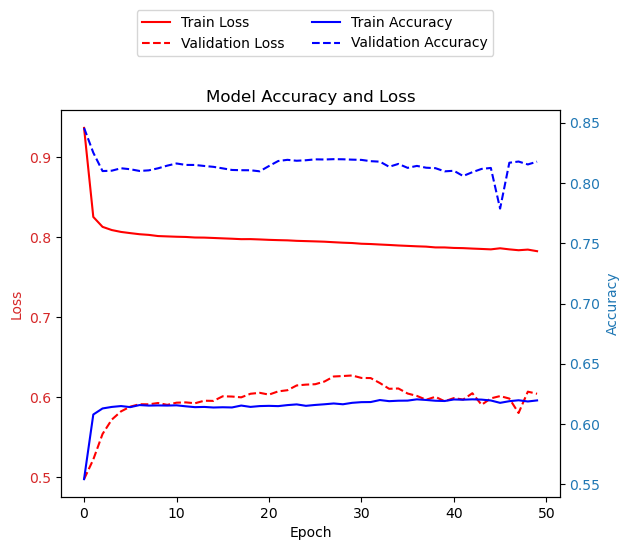

1743/1743 [==============================] - 7s 4ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 10, 'dropout': 0.02, 'accuracy': 0.8112635638059367, 'precision': 0.35500987981051607, 'recall': 0.361698286615298, 'f1': 0.3436398262744431}
preprocessing...
Training...


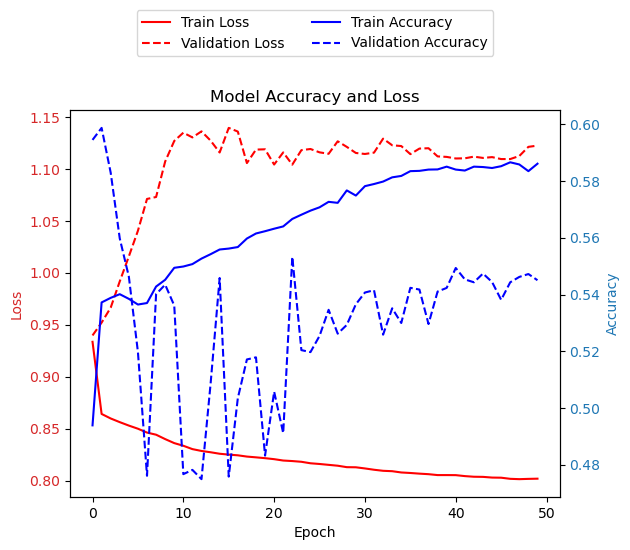

1778/1778 [==============================] - 4s 2ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 10, 'dropout': 0.05, 'accuracy': 0.34350876575990436, 'precision': 0.37282338866580056, 'recall': 0.36264037158771606, 'f1': 0.32853268056307583}
preprocessing...
Training...


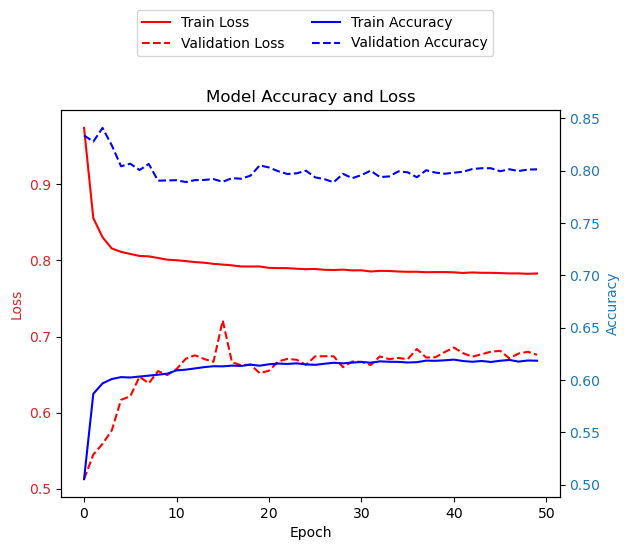

1743/1743 [==============================] - 7s 4ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'optimizer': 'rmsprop', 'cell_size': 10, 'dropout': 0.05, 'accuracy': 0.7256389561474307, 'precision': 0.35924047328939396, 'recall': 0.39014680693481435, 'f1': 0.35394121070327383}


In [28]:
# grid search with train_v9 for small dropouts and cell sizes
results_arr_11 = []
for optimizer in optimizers:
    for cell_size in cell_sizes:
        for dropout in dropout_list:
            for comb in input_output_combination: 
                try:
                    print('preprocessing...')
                    input_window = comb['input'] #***
                    output_window = comb['output'] #***

                    # Initialize empty lists to store aggregated inputs and targets
                    X_train,X_valid,X_test = [], [], []
                    Y_train,Y_valid,Y_test = [], [], []
                    # looping through symbols
                    symbols = filtered_df['crypto_symbol'].unique()
                    for s in symbols:
                        try:
                            sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                            sim_df.reset_index(inplace=True, drop=True)
                            
                            # First Loop: Calculate intervals for each column without modifying the DataFrame
                            intervals = {}
                            for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                                lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                                intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                                # getting the returns
                            reduced_df = sim_df.copy()
                            reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                            reduced_df = reduced_df[reduced_df['returns'].notna()]
                            reduced_df.reset_index(inplace=True, drop=True)

                            # Second Loop: Filter rows based on the pre-calculated intervals
                            for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                                lower_bound = intervals[column]['lower_bound']
                                upper_bound = intervals[column]['upper_bound']
                                # Apply filtering based on pre-calculated bounds
                                reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                            reduced_df.reset_index(inplace=True, drop=True)

                            # MinMax scaling
                            scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                            scaled_df = reduced_df.copy()
                            scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                            scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                            scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                            scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                            scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                            scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                            inputs_train, inputs_valid, inputs_test, targets_train, targets_valid, targets_test = pre.extract_valid_windows_v4(scaled_df,
                            'date', input_window, output_window, input_columns, ['lending_rate','borrowing_rate'],train_end_date="2023-07-01 00:00:00", valid_end_date="2024-01-25 00:00:00")

                            # Append results from the current DataFrame
                            X_train.append(inputs_train)
                            X_valid.append(inputs_valid)
                            X_test.append(inputs_test)
                            Y_train.append(targets_train)
                            Y_valid.append(targets_valid)
                            Y_test.append(targets_test)

                        # Handle any other exceptions
                        except Exception as e:
                            print(f"Unexpected error in symbol {s}: {e}")

                    # Concatenate all inputs and targets into single arrays
                    X_train = [arr for arr in X_train if len(arr) > 0]
                    X_valid = [arr for arr in X_valid if len(arr) > 0]
                    X_test = [arr for arr in X_test if len(arr) > 0]

                    Y_train = [arr for arr in Y_train if len(arr) > 0]
                    Y_valid = [arr for arr in Y_valid if len(arr) > 0]
                    Y_test = [arr for arr in Y_test if len(arr) > 0]

                    X_train  = np.concatenate(X_train, axis=0) if X_train else np.array([])
                    X_valid = np.concatenate(X_valid, axis=0) if X_valid else np.array([])
                    X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])

                    Y_train  = np.concatenate(Y_train, axis=0) if Y_train else np.array([])
                    Y_valid = np.concatenate(Y_valid, axis=0) if Y_valid else np.array([])
                    Y_test  = np.concatenate(Y_test, axis=0) if Y_test else np.array([])
                    # Lending rate
                    lending_rate_Y_train = Y_train[:, 0].reshape(Y_train.shape[0], 1) 
                    lending_rate_Y_valid = Y_valid[:, 0].reshape(Y_valid.shape[0], 1) 
                    lending_rate_Y_test = Y_test[:, 0].reshape(Y_test.shape[0], 1) 
                    # Borrowing rate
                    borrow_rate_Y_train = Y_train[:, 1].reshape(Y_train.shape[0], 1) 
                    borrow_rate_Y_valid = Y_valid[:, 1].reshape(Y_valid.shape[0], 1) 
                    borrow_rate_Y_test = Y_test[:, 1].reshape(Y_test.shape[0], 1) 

                    # Apply rebalancing
                    X_train, borrow_rate_Y_train = pre.rebalance_classes_general(X_train, borrow_rate_Y_train, balance_ratio=balancer)

                    print('Training...')
                    Y_test, y_pred = pre.train_v9(X_train,X_valid,X_test,borrow_rate_Y_train,borrow_rate_Y_valid,borrow_rate_Y_test, details=True,epochs=epoch_num, 
                                                  batch_size=bacth_size, cell_size=cell_size, dropout_rate=dropout, optimizer_name=optimizer)
                    
                    accuracy, precision, recall, f1 = pre.classification_metrics(Y_test, y_pred, printed = False)

                    total_windows = Y_test.shape[0]
                        
                    new_row = {
                        'columns': f'{input_columns}',
                        'total_test_windows':total_windows,
                        'input_window':input_window,
                        'output_window':output_window, 
                        'outlier_threshold':outlier_threshold,
                        'optimizer':optimizer,
                        'cell_size':cell_size,
                        'dropout':dropout, 
                        'accuracy':accuracy, 
                        'precision':precision, 
                        'recall':recall, 
                        'f1':f1
                    }
                    results_arr_11.append(new_row)
                    print(new_row)
                    
                except Exception as e:
                    print(f"Error occurred with {input_columns}")
                    print(f"Exception details: {e}")

results = pd.DataFrame(results_arr_11)

In [29]:
results.to_csv('very_low_dropouts.csv')
results

columns  total_test_windows  \
0   ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
1   ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
2   ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
3   ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
4   ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
5   ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
6   ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
7   ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
8   ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
9   ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   
10  ['lending_rate', 'borrowing_rate', 'utilizatio...               56869   
11  ['lending_rate', 'borrowing_rate', 'utilizatio...               55755   

    input_window  output_window outlier_threshold optimizer  cell_size  \
0             48             48            remove   rmsprop          5   
1             96              8            remove   rmsprop          5   
2             48             48            remove   rmsprop          5   
3             96              8            remove   rmsprop          5   
4             48             48            remove   rmsprop          5   
5             96              8            remove   rmsprop          5   
6             48             48            remove   rmsprop         10   
7             96              8            remove   rmsprop         10   
8             48             48            remove   rmsprop         10   
9             96              8            remove   rmsprop         10   
10            48             48            remove   rmsprop         10   
11            96              8            remove   rmsprop         10   

    dropout  accuracy  precision    recall        f1  
0      0.00  0.407006   0.376567  0.378515  0.347141  
1      0.00  0.811353   0.366026  0.376088  0.360977  
2      0.02  0.304366   0.378609  0.348451  0.293290  
3      0.02  0.407766   0.371328  0.385489  0.275751  
4      0.05  0.276179   0.327727  0.322403  0.230982  
5      0.05  0.700206   0.327705  0.331917  0.308828  
6      0.00  0.333943   0.331836  0.324744  0.304164  
7      0.00  0.695453   0.341392  0.356871  0.328653  
8      0.02  0.386555   0.392075  0.374673  0.355112  
9      0.02  0.811264   0.355010  0.361698  0.343640  
10     0.05  0.343509   0.372823  0.362640  0.328533  
11     0.05  0.725639   0.359240  0.390147  0.353941

### above results show that dropouts are needed and very low cell sizes do not help with the performance

### End of Notebook
